**CSI 4106 Introduction to Artificial Intelligence** <br/>
*Assignment 3: Neural Networks*

# Identification

Name: Joe Zhang <br/>
Student Number: 300245795

Name: Christian Paravalos<br/>
Student Number: 300231900

## 1. Exploratory Analysis

### Loading the dataset

A custom dataset has been created for this assignment. It has been made available on a public GitHub repository:

- [github.com/turcotte/csi4106-f24/tree/main/assignments-data/a3](https://github.com/turcotte/csi4106-f24/tree/main/assignments-data/a3)

Access and read the dataset directly from this GitHub repository in your Jupyter notebook.

You can use this code cell for you import statements and other initializations.

In [66]:
# Load Packages
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
import warnings

warnings.filterwarnings('default')

In [8]:
url_train = "https://raw.githubusercontent.com/turcotte/csi4106-f24/refs/heads/main/assignments-data/a3/cb513_train.csv"
url_test = "https://raw.githubusercontent.com/turcotte/csi4106-f24/refs/heads/main/assignments-data/a3/cb513_test.csv"
url_validation = "https://raw.githubusercontent.com/turcotte/csi4106-f24/refs/heads/main/assignments-data/a3/cb513_valid.csv"

train_data = pd.read_csv(url_train, header = None)
test_data = pd.read_csv(url_test, header = None)
valid_data = pd.read_csv(url_validation, header = None)

### Data Pre-Processing

2. **Shuffling the Rows**:

    - Since examples are generated by sliding a window across each protein sequence, most adjacent examples originate from the same protein and share 20 positions. To mitigate the potential negative impact on model training, the initial step involves shuffling the **rows** of the data matrix.

In [10]:
# We shuffle the rows of the data
train_data = train_data.sample(frac = 1)
test_data = test_data.sample(frac = 1)
valid_data = valid_data.sample(frac = 1)

3. **Scaling of Numerical Features**:

    - Since all 462 features are proportions represented as values between 0 and 1, scaling may not be necessary. In our evaluations, using [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) actually degraded model performance. Within your pipeline, compare the effects of not scaling the data versus applying [MinMaxScaler](https://scikit-learn.org/1.5/modules/generated/sklearn.preprocessing.MinMaxScaler.html). In the interest of time, a single experiment will suffice. It is important to note that when scaling is applied, a uniform method should be used across all columns, given their homogeneous nature.

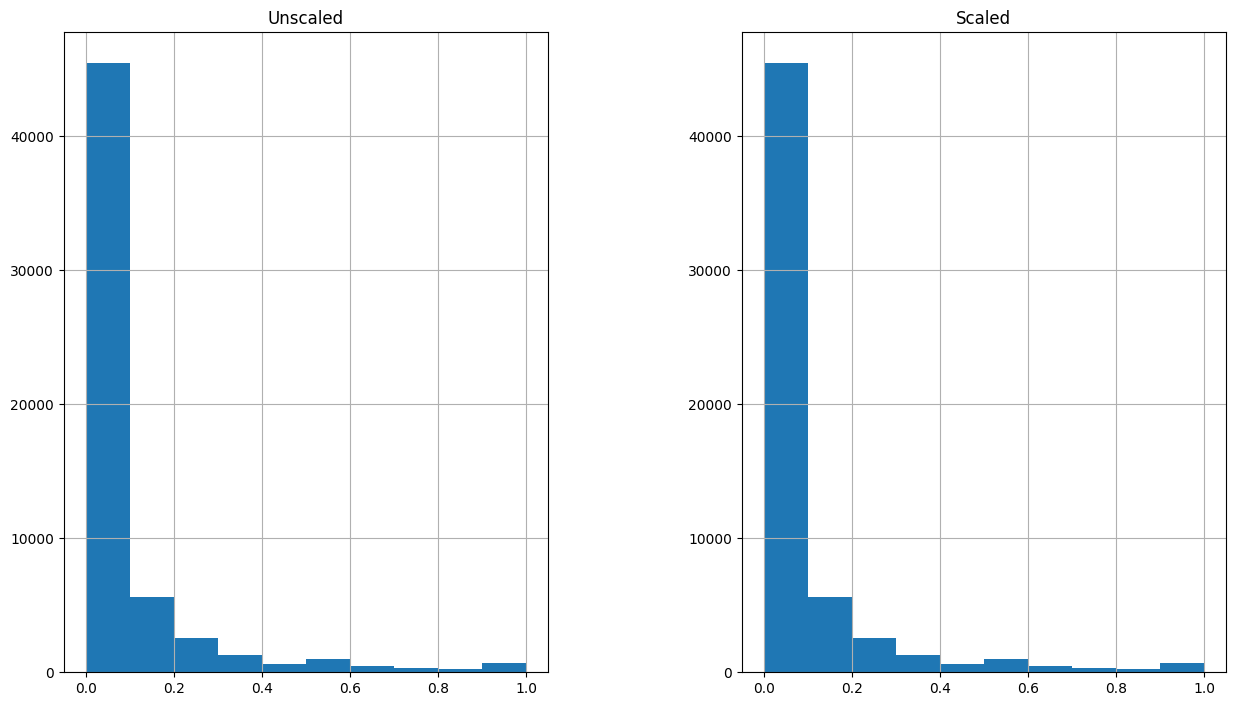

In [33]:
# We create a dataframe that stores the scaled dataset
scaler = MinMaxScaler()
scaler = scaler.fit(train_data)
scaled_data = scaler.transform(train_data)

scaled_data = pd.DataFrame(scaled_data)

# We display charts showing the distributions of the first feature comparing scaled and non-scaled
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 8))

train_data.hist(column = 1, ax = axes[0])
axes[0].set_title("Unscaled")

scaled_data.hist(column = 1, ax = axes[1])
axes[1].set_title("Scaled")

plt.subplots_adjust(top=0.9, bottom=0.1, hspace=0.4, wspace=0.4)

plt.show()

We scaled the features of the data using MinMaxScaler. Above are the histograms of the first column of the dataframe, before and after scaling. We have seen that there are no differences between the graphs. This is because that the maximum is 1 and the minimum is 0 for the column, so normalization has no effect on the data. Therefore, we believe that scaling is not necessary with this dataset.

4. **Isolating the Target and the Data**:

    - In the CSV files, the target and data are combined. To prepare for our machine learning experiments, separate the training data $X$ and the target vector $y$ for each of the three datasets.

In [69]:
# Code cell
X_train = train_data.drop(columns = [0])
y_train = train_data[0]

X_test = test_data.drop(columns = [0])
y_test = test_data[0]

X_valid = valid_data.drop(columns = [0])
y_valid = valid_data[0]

### Model Development & Evaluation

5. **Model Development**:

    - **Dummy Model**: Implement a model utilizing the [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html). This model disregards the input data and predicts the majority class. Such model is sometimes called a straw man model.

    - **Basline Model**: As a baseline model, select one of the previously studied machine learning algorithms: Decision Trees, K-Nearest Neighbors (KNN), or Logistic Regression. Use the default parameters provided by scikit-learn to train each model as a baseline. Why did you choose this particular classifier? Why do you think it should be appropriate for this specific task?

    - **Neural Network Model**: Utilizing [Keras](https://keras.io) and [TensorFlow](https://www.tensorflow.org), construct a sequential model comprising an input layer, a hidden layer, and an output layer. The input layer should consist of 462 nodes, reflecting the 462 attributes of each example. The hidden layer should include 8 nodes and employ the default activation function. The output layer should contain three nodes, corresponding to the three classes: helix (0), sheet (1), and coil (2). Apply the softmax activation function to the output layer to ensure that the outputs are treated as probabilities, with their sum equaling 1 for each training example.

    We therefore have three models: dummy, baseline, and neural network.

In [70]:
# Dummy Model
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train)

DummyClassifier()

In [132]:
# Baseline Model
# Note: I'm training all 3 models for now. We're only keeping one of them.
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

logit_clf = LogisticRegression()
logit_clf.fit(X_train, y_train)

y_train_pred = tree_clf.predict(X_train)

print(classification_report(y_train, y_train_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21634
           1       1.00      1.00      1.00     12671
           2       1.00      1.00      1.00     23986

    accuracy                           1.00     58291
   macro avg       1.00      1.00      1.00     58291
weighted avg       1.00      1.00      1.00     58291



In [153]:
# Neural Network
tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(8))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 306us/step - accuracy: 0.6050 - loss: 0.8780 - val_accuracy: 0.6734 - val_loss: 0.7711
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step - accuracy: 0.6862 - loss: 0.7476 - val_accuracy: 0.6749 - val_loss: 0.7697
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step - accuracy: 0.6879 - loss: 0.7455 - val_accuracy: 0.6747 - val_loss: 0.7693
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step - accuracy: 0.6882 - loss: 0.7445 - val_accuracy: 0.6744 - val_loss: 0.7690
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step - accuracy: 0.6884 - loss: 0.7437 - val_accuracy: 0.6750 - val_loss: 0.7689
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step - accuracy: 0.6887 - loss: 0.7430 - val_accuracy: 0.6755 - val_loss: 0.7688
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step - accuracy: 0.6889 - loss: 0.7424 - val_accuracy: 0.6753 - val_loss: 0.7688
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step - accuracy: 0.6890 -

6. **Model Evaluation**:

    - Employ cross-validation to assess the performance of the baseline model. Select a small number of folds to prevent excessive computational demands.

In [77]:
# We now run cross-validation to evaluate the baseline model

# We evaluate all 3 models for now. We decide on one later

# Create the scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average = 'micro'),
    'recall': make_scorer(recall_score, average = 'micro'),
    'f1_score': make_scorer(f1_score, average = 'micro')
}

cv_folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

clf_scores_dt = cross_validate(tree_clf, X_train, y_train, cv = cv_folds, scoring = scoring)
clf_scores_knn = cross_validate(knn_clf, X_train, y_train, cv = cv_folds, scoring = scoring)
clf_scores_logit = cross_validate(logit_clf, X_train, y_train, cv = cv_folds, scoring = scoring)

# Print the results in tabular form for decision tree
print("Statistics per fold (Decision Tree):")
print(f"{'Fold':<10} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-score':<10}")

# Display the statistics for EACH fold
for i in range(len(clf_scores_dt['test_accuracy'])):
    print(f"{i+1:<10} {clf_scores_dt['test_accuracy'][i]:<10.3f} {clf_scores_dt['test_precision'][i]:<10.3f} "
          f"{clf_scores_dt['test_recall'][i]:<10.3f} {clf_scores_dt['test_f1_score'][i]:<10.3f}")

# Display the mean statistics across ALL folds
print("\nMean statistics over all folds (Decision Tree):")
print(f"Mean Accuracy: {clf_scores_dt['test_accuracy'].mean():.3f}")
print(f"Mean Precision: {clf_scores_dt['test_precision'].mean():.3f}")
print(f"Mean Recall: {clf_scores_dt['test_recall'].mean():.3f}")
print(f"Mean F1-Score: {clf_scores_dt['test_f1_score'].mean():.3f}")

# Print the results in tabular form for K Nearest Neighbors
print("\nStatistics per fold (kNN):")
print(f"{'Fold':<10} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-score':<10}")

# Display the statistics for EACH folds
for i in range(len(clf_scores_knn['test_accuracy'])):
    print(f"{i+1:<10} {clf_scores_knn['test_accuracy'][i]:<10.3f} {clf_scores_knn['test_precision'][i]:<10.3f} "
          f"{clf_scores_knn['test_recall'][i]:<10.3f} {clf_scores_knn['test_f1_score'][i]:<10.3f}")

# Display the mean statistics across ALL folds
print("\nMean statistics over all folds (kNN):")
print(f"Mean Accuracy: {clf_scores_knn['test_accuracy'].mean():.3f}")
print(f"Mean Precision: {clf_scores_knn['test_precision'].mean():.3f}")
print(f"Mean Recall: {clf_scores_knn['test_recall'].mean():.3f}")
print(f"Mean F1-Score: {clf_scores_knn['test_f1_score'].mean():.3f}")

# Print the results in tabular form for Logistic Regression
print("\nStatistics per fold (Logistic Regression):")
print(f"{'Fold':<10} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-score':<10}")

# Display the statistics for EACH folds
for i in range(len(clf_scores_logit['test_accuracy'])):
    print(f"{i+1:<10} {clf_scores_logit['test_accuracy'][i]:<10.3f} {clf_scores_logit['test_precision'][i]:<10.3f} "
          f"{clf_scores_logit['test_recall'][i]:<10.3f} {clf_scores_logit['test_f1_score'][i]:<10.3f}")

# Display the mean statistics across ALL folds
print("\nMean statistics over all folds (Logistic Regression):")
print(f"Mean Accuracy: {clf_scores_logit['test_accuracy'].mean():.3f}")
print(f"Mean Precision: {clf_scores_logit['test_precision'].mean():.3f}")
print(f"Mean Recall: {clf_scores_logit['test_recall'].mean():.3f}")
print(f"Mean F1-Score: {clf_scores_logit['test_f1_score'].mean():.3f}")



Statistics per fold (Decision Tree):
Fold       Accuracy   Precision  Recall     F1-score  
1          0.497      0.497      0.497      0.497     
2          0.501      0.501      0.501      0.501     
3          0.498      0.498      0.498      0.498     
4          0.504      0.504      0.504      0.504     
5          0.496      0.496      0.496      0.496     

Mean statistics over all folds (Decision Tree):
Mean Accuracy: 0.499
Mean Precision: 0.499
Mean Recall: 0.499
Mean F1-Score: 0.499

Statistics per fold (kNN):
Fold       Accuracy   Precision  Recall     F1-score  
1          0.469      0.469      0.469      0.469     
2          0.469      0.469      0.469      0.469     
3          0.463      0.463      0.463      0.463     
4          0.465      0.465      0.465      0.465     
5          0.461      0.461      0.461      0.461     

Mean statistics over all folds (kNN):
Mean Accuracy: 0.465
Mean Precision: 0.465
Mean Recall: 0.465
Mean F1-Score: 0.465

Statistics per fold 

- **Training neural networks can be time-consuming**. Consequently, their performance is typically assessed once using a validation set. Make sure to not use the test set until the very end of the assignment.

In [154]:
# We now evaluate the neural network model using the validation set
model.evaluate(X_valid, y_valid)

232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step - accuracy: 0.6781 - loss: 0.7669


[0.7717868089675903, 0.6768794655799866]


- Assess the models using metrics such as precision, recall, and F1-score.

### Hyperparameter Optimization

7. **Baseline Model:**

    - To ensure a fair comparison for our baseline model, we will examine how varying hyperparameter values affect its performance. This prevents the erroneous conclusion that neural networks inherently perform better, when in fact, appropriate hyperparameter tuning could enhance the baseline model's performance.

    - Focus on the following relevant hyperparameters for each model:

        - [DecisionTreeClassifier](https://scikit-learn.org/dev/modules/generated/sklearn.tree.DecisionTreeClassifier.html): `criterion` and `max_depth`.
  
        - [LogisticRegression](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html): `penalty`, `max_iter`, and `tol`.
  
        - [KNeighborsClassifier](https://scikit-learn.org/dev/modules/generated/sklearn.neighbors.KNeighborsClassifier.html): `n_neighbors` and `weights`.

    - Employ a grid search strategy or utilize scikit-learn's built-in methods [GridSearchCV](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html) to thoroughly evaluate all combinations of hyperparameter values. Cross-validation should be used to assess each combination.

    - Quantify the performance of each hyperparameter configuration using precision, recall, and F1-score as metrics.

    - Analyze the findings and offer insights into which hyperparameter configurations achieved optimal performance for each model.

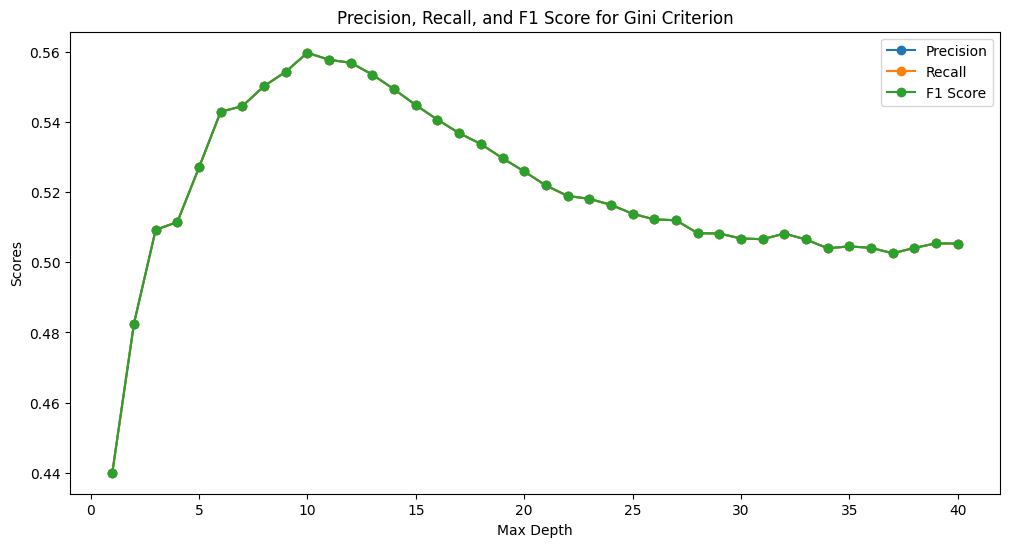

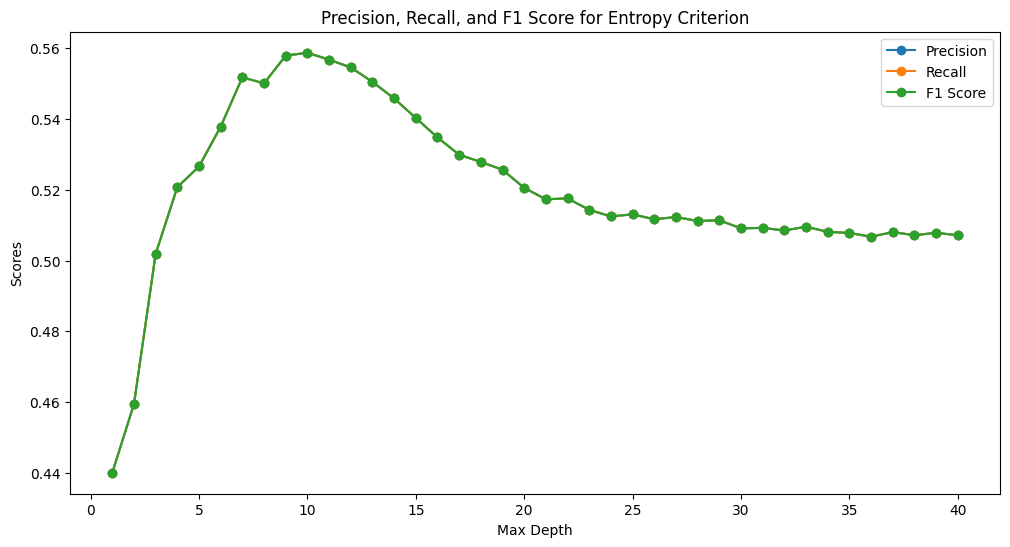

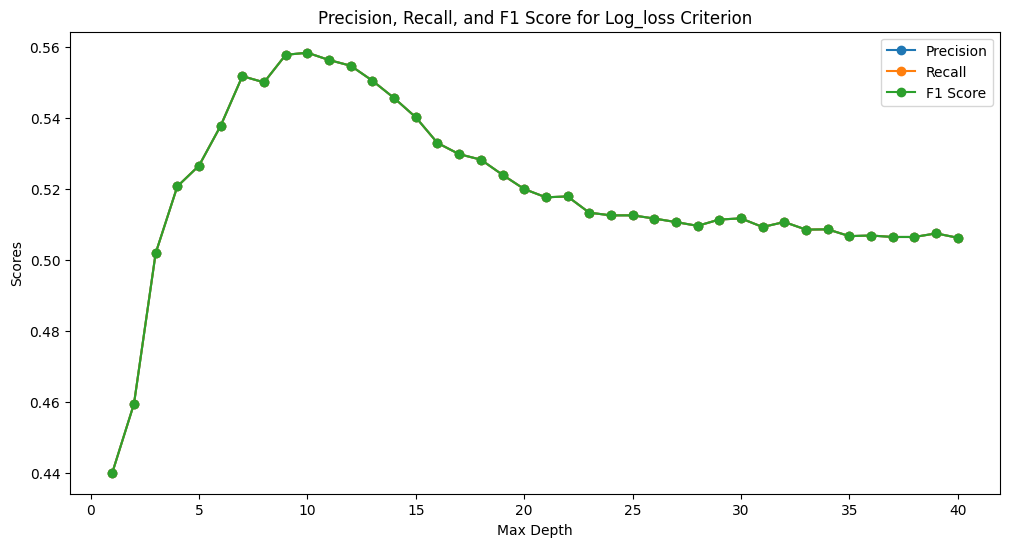

In [79]:
# We now find the best parameters for baseline models
scoring = {
    'precision': make_scorer(precision_score, average = 'micro'),
    'recall': make_scorer(recall_score, average = 'micro'),
    'f1_score': make_scorer(f1_score, average = 'micro')
}

criteria = ['gini', 'entropy', 'log_loss']
max_depth_range = range(1, 41)

param_grid_dt = {
    'criterion': criteria,
    'max_depth': max_depth_range
}

grid_search_dt = GridSearchCV(tree_clf, param_grid_dt, cv = 5, scoring = scoring, refit = 'f1_score')
grid_search_dt.fit(X_train, y_train)

# Initialize a dictionary to store scores for each criterion and max_depth combination
results = {criterion: {'precision': [], 'recall': [], 'f1_score': []} for criterion in criteria}

# Loop over each criterion to extract metrics for each value of max_depth
for criterion in criteria:
    for depth in max_depth_range:
        # Find index where the current criterion and max_depth are used
        index = [
            i for i, params in enumerate(grid_search_dt.cv_results_['params'])
            if params['criterion'] == criterion and params['max_depth'] == depth][0]

        # Append the corresponding scores to the results dictionary
        results[criterion]['precision'].append(grid_search_dt.cv_results_['mean_test_precision'][index])
        results[criterion]['recall'].append(grid_search_dt.cv_results_['mean_test_recall'][index])
        results[criterion]['f1_score'].append(grid_search_dt.cv_results_['mean_test_f1_score'][index])

# Plotting each criterion separately with smoothed lines
for criterion in criteria:
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot smoothed lines for precision, recall, and f1-scores for each max_depth value
    ax.plot(max_depth_range, results[criterion]['precision'], label='Precision', marker='o')
    ax.plot(max_depth_range, results[criterion]['recall'], label='Recall', marker='o')
    ax.plot(max_depth_range, results[criterion]['f1_score'], label='F1 Score', marker='o')

    # Add labels, title, and legend
    ax.set_xlabel('Max Depth')
    ax.set_ylabel('Scores')
    ax.set_title(f'Precision, Recall, and F1 Score for {criterion.capitalize()} Criterion')
    ax.legend()

    # Show plot
    plt.show()

8. **Neural Network:**

    In our exploration and tuning of neural networks, we focus on the following hyperparameters:

    - **Single hidden layer, varying the number of nodes**. 

        - Start with a single node in the hidden layer. Use a graph to depict the progression of loss and accuracy for both the training and validation sets, with the horizontal axis representing the number of training epochs and the vertical axis showing loss and accuracy. Training this network should be relatively fast, so let's conduct training for 50 epochs. Observing the graph, what do you conclude? Is the network underfitting or overfitting? Why?

        - Repeat the above process using 2 and 4 nodes in the hidden layer. Use the same type of graph to document your observations regarding loss and accuracy.

        - Start with 8 nodes in the hidden layer and progressively double the number of nodes until it surpasses the number of nodes in the input layer. This results in seven experiments and corresponding graphs for the following configurations: 8, 16, 32, 64, 128, 256, and 512 nodes. Document your observations throughout the process.
        
        - Ensure that the **number of training epochs** is adequate for **observing an increase in validation loss**. **Tip**: During model development, start with a small number of epochs, such as 5 or 10. Once the model appears to perform well, test with larger values, like 40 or 80 epochs, which proved reasonable in our tests. Based on your observations, consider conducting further experiments, if needed. How many epochs were ultimately necessary?

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 271us/step - accuracy: 0.5164 - loss: 1.0064 - val_accuracy: 0.5848 - val_loss: 0.8982
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step - accuracy: 0.6012 - loss: 0.8743 - val_accuracy: 0.5924 - val_loss: 0.8903
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step - accuracy: 0.6104 - loss: 0.8664 - val_accuracy: 0.5968 - val_loss: 0.8886
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step - accuracy: 0.6145 - loss: 0.8635 - val_accuracy: 0.6006 - val_loss: 0.8878
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step - accuracy: 0.6166 - loss: 0.8621 - val_accuracy: 0.6025 - val_loss: 0.8875
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step - accuracy: 0.6181 - loss: 0.8613 - val_accuracy: 0.6010 - val_loss: 0.8874
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step - accuracy: 0.6188 - loss: 0.8608 - val_accuracy: 0.6018 - val_loss: 0.8874
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step - accuracy: 0.6187 -

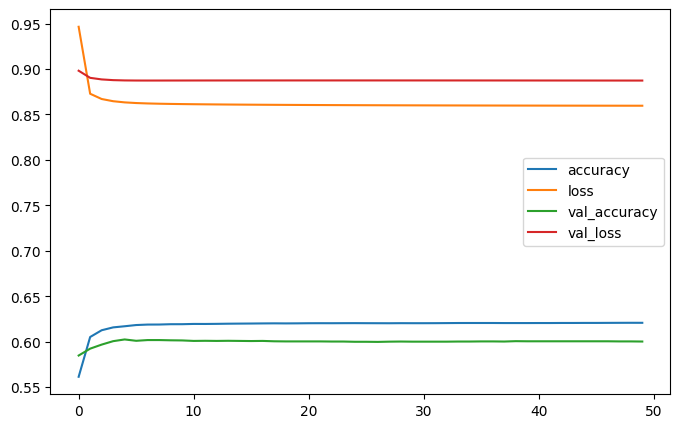

In [160]:
# We now evaluate neural networks with one hidden layer and varying number of nodes

# For this part, we have one node in the hidden layer
tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = (462, )))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step - accuracy: 0.5438 - loss: 0.9615 - val_accuracy: 0.6716 - val_loss: 0.7856
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step - accuracy: 0.6839 - loss: 0.7530 - val_accuracy: 0.6751 - val_loss: 0.7686
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step - accuracy: 0.6903 - loss: 0.7425 - val_accuracy: 0.6743 - val_loss: 0.7682
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step - accuracy: 0.6909 - loss: 0.7410 - val_accuracy: 0.6738 - val_loss: 0.7683
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step - accuracy: 0.6908 - loss: 0.7403 - val_accuracy: 0.6739 - val_loss: 0.7683
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step - accuracy: 0.6909 - loss: 0.7398 - val_accuracy: 0.6742 - val_loss: 0.7683
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step - accuracy: 0.6912 - loss: 0.7394 - val_accuracy: 0.6743 - val_loss: 0.7683
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step - accuracy: 0.6915 -

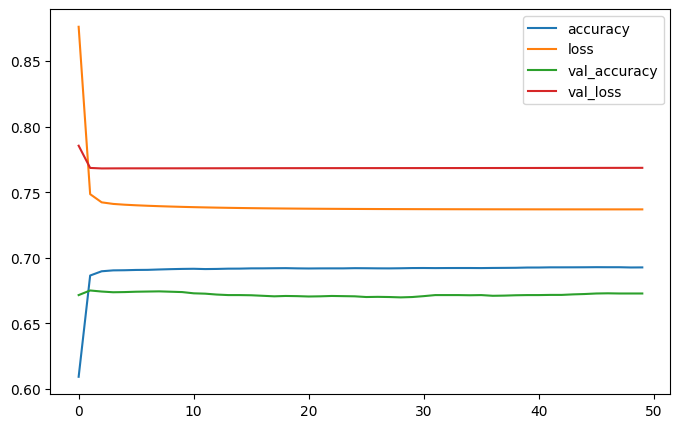

In [144]:
# For this part, we have 2 nodes in the hidden layer
tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(2))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 278us/step - accuracy: 0.5921 - loss: 0.8977 - val_accuracy: 0.6739 - val_loss: 0.7716
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step - accuracy: 0.6871 - loss: 0.7462 - val_accuracy: 0.6759 - val_loss: 0.7688
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step - accuracy: 0.6881 - loss: 0.7436 - val_accuracy: 0.6759 - val_loss: 0.7687
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step - accuracy: 0.6890 - loss: 0.7427 - val_accuracy: 0.6759 - val_loss: 0.7686
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step - accuracy: 0.6890 - loss: 0.7419 - val_accuracy: 0.6757 - val_loss: 0.7684
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step - accuracy: 0.6893 - loss: 0.7413 - val_accuracy: 0.6757 - val_loss: 0.7682
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step - accuracy: 0.6894 - loss: 0.7408 - val_accuracy: 0.6755 - val_loss: 0.7681
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step - accuracy: 0.6902 -

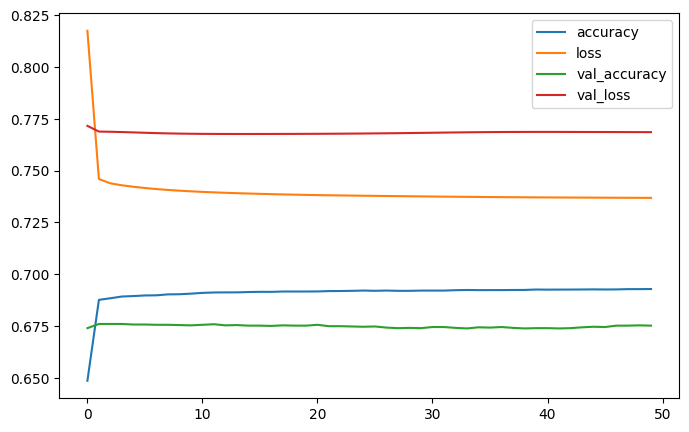

In [82]:
# For this part, we have 4 nodes in the hidden layer
tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(4))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 290us/step - accuracy: 0.6023 - loss: 0.8763 - val_accuracy: 0.6746 - val_loss: 0.7703
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step - accuracy: 0.6865 - loss: 0.7481 - val_accuracy: 0.6750 - val_loss: 0.7697
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step - accuracy: 0.6872 - loss: 0.7464 - val_accuracy: 0.6754 - val_loss: 0.7696
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step - accuracy: 0.6882 - loss: 0.7454 - val_accuracy: 0.6758 - val_loss: 0.7694
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step - accuracy: 0.6881 - loss: 0.7446 - val_accuracy: 0.6751 - val_loss: 0.7693
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step - accuracy: 0.6882 - loss: 0.7438 - val_accuracy: 0.6750 - val_loss: 0.7693
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step - accuracy: 0.6886 - loss: 0.7432 - val_accuracy: 0.6746 - val_loss: 0.7691
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step - accuracy: 0.6886 -

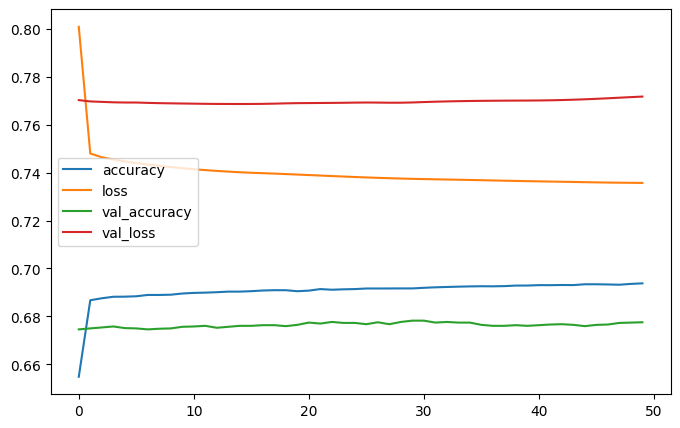

In [83]:
# For this part, we have 8 nodes in the hidden layer
tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(8))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 291us/step - accuracy: 0.6174 - loss: 0.8583 - val_accuracy: 0.6734 - val_loss: 0.7723
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step - accuracy: 0.6854 - loss: 0.7502 - val_accuracy: 0.6751 - val_loss: 0.7711
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step - accuracy: 0.6863 - loss: 0.7481 - val_accuracy: 0.6767 - val_loss: 0.7705
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step - accuracy: 0.6872 - loss: 0.7467 - val_accuracy: 0.6759 - val_loss: 0.7702
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step - accuracy: 0.6878 - loss: 0.7456 - val_accuracy: 0.6753 - val_loss: 0.7700
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 271us/step - accuracy: 0.6879 - loss: 0.7447 - val_accuracy: 0.6765 - val_loss: 0.7701
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step - accuracy: 0.6883 - loss: 0.7440 - val_accuracy: 0.6769 - val_loss: 0.7702
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step - accuracy: 0.6882 -

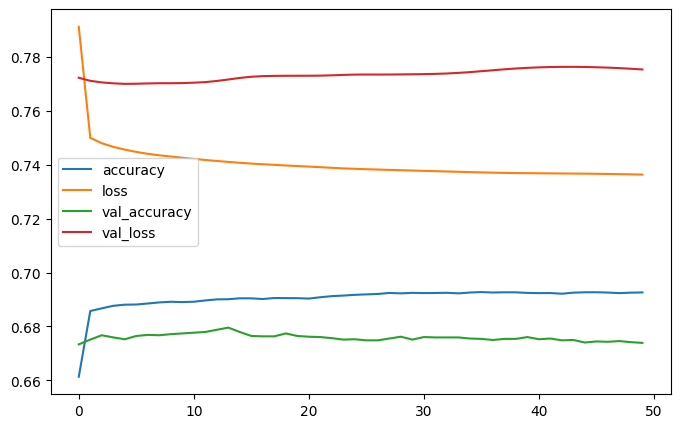

In [84]:
# For this part, we have 16 nodes in the hidden layer
tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(16))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 314us/step - accuracy: 0.6316 - loss: 0.8354 - val_accuracy: 0.6726 - val_loss: 0.7745
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 273us/step - accuracy: 0.6846 - loss: 0.7534 - val_accuracy: 0.6746 - val_loss: 0.7725
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 273us/step - accuracy: 0.6846 - loss: 0.7504 - val_accuracy: 0.6751 - val_loss: 0.7717
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 278us/step - accuracy: 0.6856 - loss: 0.7483 - val_accuracy: 0.6757 - val_loss: 0.7713
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 273us/step - accuracy: 0.6868 - loss: 0.7467 - val_accuracy: 0.6762 - val_loss: 0.7712
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step - accuracy: 0.6871 - loss: 0.7454 - val_accuracy: 0.6750 - val_loss: 0.7718
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 275us/step - accuracy: 0.6876 - loss: 0.7445 - val_accuracy: 0.6759 - val_loss: 0.7722
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step - accuracy: 0.6880 -

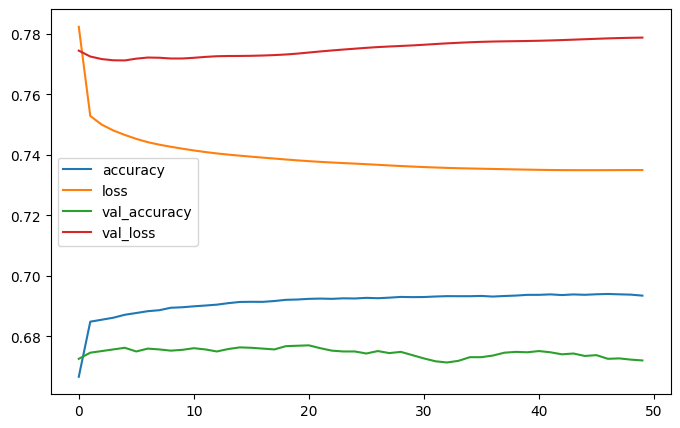

In [85]:
# For this part, we have 32 nodes in the hidden layer
tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 360us/step - accuracy: 0.6414 - loss: 0.8238 - val_accuracy: 0.6731 - val_loss: 0.7779
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 320us/step - accuracy: 0.6829 - loss: 0.7569 - val_accuracy: 0.6759 - val_loss: 0.7749
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 326us/step - accuracy: 0.6840 - loss: 0.7525 - val_accuracy: 0.6758 - val_loss: 0.7741
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 318us/step - accuracy: 0.6852 - loss: 0.7497 - val_accuracy: 0.6762 - val_loss: 0.7738
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 315us/step - accuracy: 0.6866 - loss: 0.7474 - val_accuracy: 0.6757 - val_loss: 0.7739
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 318us/step - accuracy: 0.6881 - loss: 0.7455 - val_accuracy: 0.6749 - val_loss: 0.7745
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 314us/step - accuracy: 0.6883 - loss: 0.7442 - val_accuracy: 0.6735 - val_loss: 0.7756
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 319us/step - accuracy: 0.6886 -

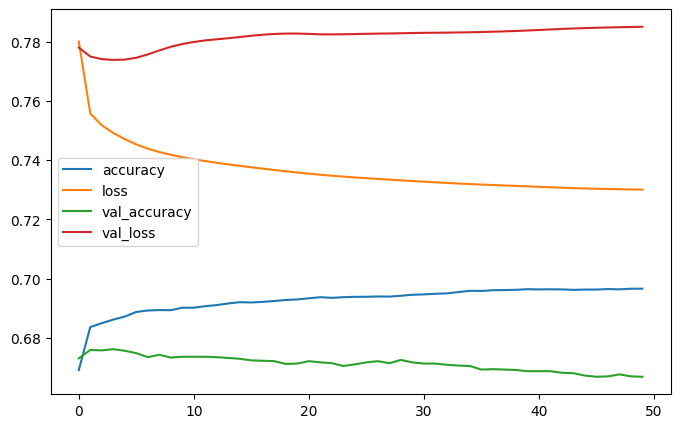

In [86]:
# For this part, we have 64 nodes in the hidden layer
tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 411us/step - accuracy: 0.6467 - loss: 0.8157 - val_accuracy: 0.6727 - val_loss: 0.7792
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 382us/step - accuracy: 0.6822 - loss: 0.7579 - val_accuracy: 0.6757 - val_loss: 0.7754
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 372us/step - accuracy: 0.6840 - loss: 0.7521 - val_accuracy: 0.6758 - val_loss: 0.7751
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 361us/step - accuracy: 0.6859 - loss: 0.7484 - val_accuracy: 0.6749 - val_loss: 0.7759
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 363us/step - accuracy: 0.6870 - loss: 0.7456 - val_accuracy: 0.6742 - val_loss: 0.7768
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 376us/step - accuracy: 0.6885 - loss: 0.7434 - val_accuracy: 0.6720 - val_loss: 0.7779
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 374us/step - accuracy: 0.6902 - loss: 0.7416 - val_accuracy: 0.6727 - val_loss: 0.7791
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 360us/step - accuracy: 0.6906 -

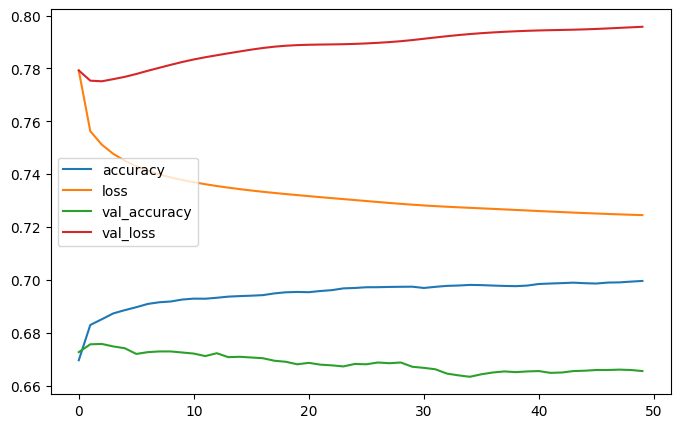

In [87]:
# For this part, we have 128 nodes in the hidden layer
tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 615us/step - accuracy: 0.6462 - loss: 0.8136 - val_accuracy: 0.6739 - val_loss: 0.7819
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 561us/step - accuracy: 0.6810 - loss: 0.7594 - val_accuracy: 0.6738 - val_loss: 0.7790
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 552us/step - accuracy: 0.6837 - loss: 0.7523 - val_accuracy: 0.6727 - val_loss: 0.7810
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 543us/step - accuracy: 0.6869 - loss: 0.7474 - val_accuracy: 0.6727 - val_loss: 0.7836
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 556us/step - accuracy: 0.6893 - loss: 0.7437 - val_accuracy: 0.6727 - val_loss: 0.7856
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 554us/step - accuracy: 0.6913 - loss: 0.7409 - val_accuracy: 0.6720 - val_loss: 0.7872
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 567us/step - accuracy: 0.6927 - loss: 0.7387 - val_accuracy: 0.6712 - val_loss: 0.7885
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 552us/step - accuracy: 0.6940 -

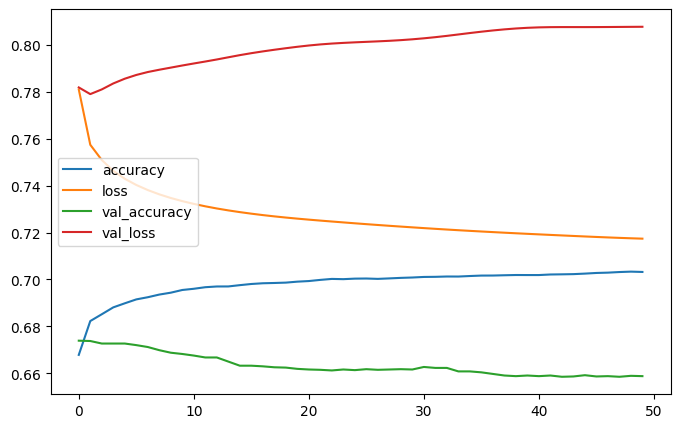

In [88]:
# For this part, we have 256 nodes in the hidden layer
tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 2s 843us/step - accuracy: 0.6460 - loss: 0.8139 - val_accuracy: 0.6723 - val_loss: 0.7837
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 778us/step - accuracy: 0.6807 - loss: 0.7599 - val_accuracy: 0.6719 - val_loss: 0.7826
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 2s 950us/step - accuracy: 0.6855 - loss: 0.7508 - val_accuracy: 0.6697 - val_loss: 0.7858
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 812us/step - accuracy: 0.6892 - loss: 0.7445 - val_accuracy: 0.6682 - val_loss: 0.7887
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 790us/step - accuracy: 0.6923 - loss: 0.7401 - val_accuracy: 0.6669 - val_loss: 0.7912
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 794us/step - accuracy: 0.6943 - loss: 0.7368 - val_accuracy: 0.6661 - val_loss: 0.7935
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 786us/step - accuracy: 0.6950 - loss: 0.7342 - val_accuracy: 0.6646 - val_loss: 0.7956
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 2s 824us/step - accuracy: 0.6961 -

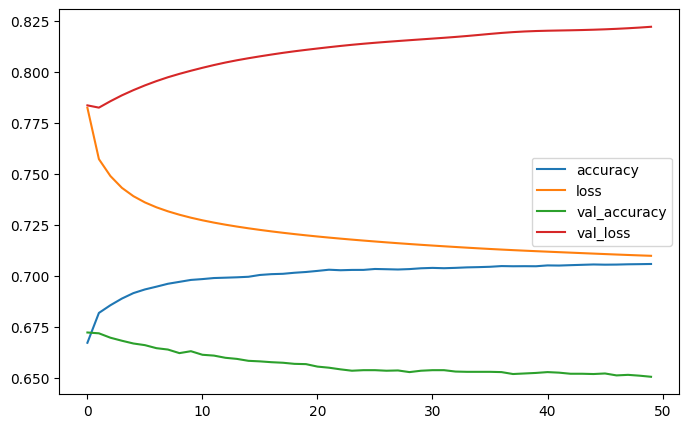

In [89]:
# For this part, we have 512 nodes in the hidden layer
tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

We trained all the neural networks with 50 epochs. We found that as we progressively increase the number of node in the hidden layer, we see that the validation loss increases at a smaller number of epochs and more sharply. Similarly, the validation accuracy also decreases at a smaller number of epochs. This is most likely because of overfitting with too many nodes in the hidden layer and too many epochs. We also notice that both training and validation losses are high when there are very few nodes in the hidden layer, indicating underfitting. From looking at all the experiments, we think that the neural networks with 2 or 4 hidden layers are the most suitable since they don't have very high losses. Starting at with 8 nodes, the validation loss increases more sharply with more epochs.

 - **Varying the number of layers**.

    - Conduct similar experiments as described above, but this time vary the number of layers from 1 to 4. Document your findings.

    - How many nodes should each layer contain? Test at least two scenarios. Traditionally, a common strategy involved decreasing the number of nodes from the input layer to the output layer, often by halving, to create a pyramid-like structure. However, recent experience suggests that maintaining a constant number of nodes across all layers can perform equally well. Describe your observations. It is acceptable if both strategies yield similar performance results.

     - Select one your models that exemplifies overfitting. In our experiments, we easily constructed a model achieving nearly 100% accuracy on the training data, yet showing no similar improvement on the validation set. Present this neural network along with its accuracy and loss graphs. Explain the reasoning for concluding that the model is overfitting.

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 288us/step - accuracy: 0.5301 - loss: 0.9850 - val_accuracy: 0.5935 - val_loss: 0.9034
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step - accuracy: 0.6152 - loss: 0.8741 - val_accuracy: 0.6018 - val_loss: 0.8919
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step - accuracy: 0.6194 - loss: 0.8657 - val_accuracy: 0.6024 - val_loss: 0.8893
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step - accuracy: 0.6195 - loss: 0.8637 - val_accuracy: 0.6032 - val_loss: 0.8885
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step - accuracy: 0.6201 - loss: 0.8629 - val_accuracy: 0.6021 - val_loss: 0.8882
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step - accuracy: 0.6197 - loss: 0.8623 - val_accuracy: 0.6017 - val_loss: 0.8880
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step - accuracy: 0.6197 - loss: 0.8619 - val_accuracy: 0.6017 - val_loss: 0.8878
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step - accuracy: 0.6197 -

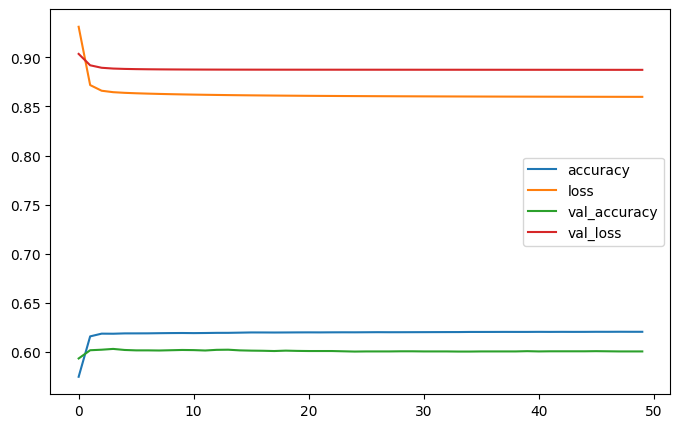

In [90]:
# 2 layers, 1 node in each hidden layer
tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1))
model.add(tf.keras.layers.Dense(1))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 294us/step - accuracy: 0.5284 - loss: 0.9834 - val_accuracy: 0.5947 - val_loss: 0.9012
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step - accuracy: 0.6156 - loss: 0.8737 - val_accuracy: 0.6025 - val_loss: 0.8914
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 294us/step - accuracy: 0.6192 - loss: 0.8661 - val_accuracy: 0.6037 - val_loss: 0.8893
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 289us/step - accuracy: 0.6192 - loss: 0.8642 - val_accuracy: 0.6031 - val_loss: 0.8886
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step - accuracy: 0.6190 - loss: 0.8633 - val_accuracy: 0.6025 - val_loss: 0.8883
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step - accuracy: 0.6193 - loss: 0.8627 - val_accuracy: 0.6022 - val_loss: 0.8880
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step - accuracy: 0.6195 - loss: 0.8623 - val_accuracy: 0.6021 - val_loss: 0.8879
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step - accuracy: 0.6194 -

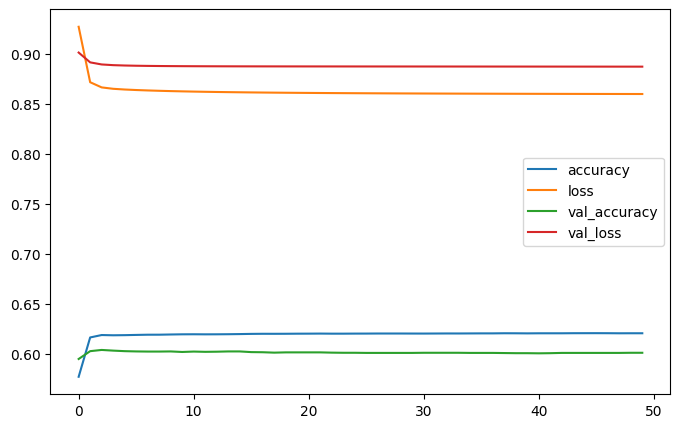

In [91]:
# 2 layers, 2 nodes in layer 1, 1 node in layer 2

tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(2))
model.add(tf.keras.layers.Dense(1))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 287us/step - accuracy: 0.5551 - loss: 0.9421 - val_accuracy: 0.6724 - val_loss: 0.7748
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step - accuracy: 0.6874 - loss: 0.7470 - val_accuracy: 0.6751 - val_loss: 0.7693
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step - accuracy: 0.6898 - loss: 0.7417 - val_accuracy: 0.6751 - val_loss: 0.7687
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step - accuracy: 0.6901 - loss: 0.7406 - val_accuracy: 0.6754 - val_loss: 0.7686
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step - accuracy: 0.6899 - loss: 0.7401 - val_accuracy: 0.6755 - val_loss: 0.7685
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step - accuracy: 0.6903 - loss: 0.7396 - val_accuracy: 0.6758 - val_loss: 0.7685
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step - accuracy: 0.6907 - loss: 0.7392 - val_accuracy: 0.6751 - val_loss: 0.7686
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step - accuracy: 0.6907 -

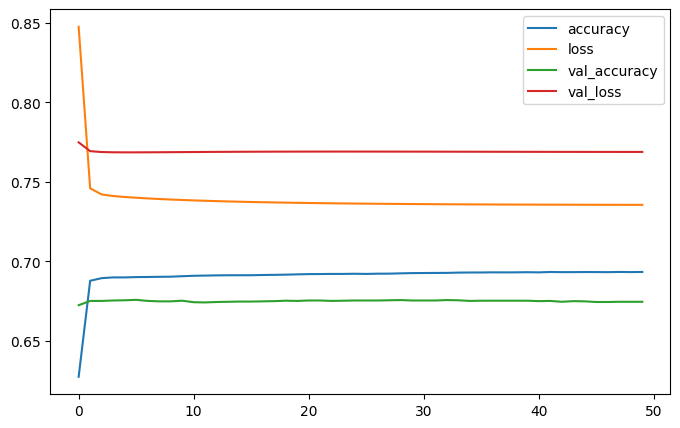

In [92]:
# 2 layers, 2 nodes in layer 1, 2 nodes in layer 2

tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(2))
model.add(tf.keras.layers.Dense(2))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 325us/step - accuracy: 0.5858 - loss: 0.8920 - val_accuracy: 0.6734 - val_loss: 0.7733
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step - accuracy: 0.6869 - loss: 0.7475 - val_accuracy: 0.6751 - val_loss: 0.7700
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step - accuracy: 0.6885 - loss: 0.7450 - val_accuracy: 0.6757 - val_loss: 0.7693
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step - accuracy: 0.6885 - loss: 0.7438 - val_accuracy: 0.6757 - val_loss: 0.7689
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step - accuracy: 0.6889 - loss: 0.7428 - val_accuracy: 0.6753 - val_loss: 0.7687
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step - accuracy: 0.6895 - loss: 0.7419 - val_accuracy: 0.6759 - val_loss: 0.7686
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step - accuracy: 0.6900 - loss: 0.7412 - val_accuracy: 0.6753 - val_loss: 0.7685
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step - accuracy: 0.6903 -

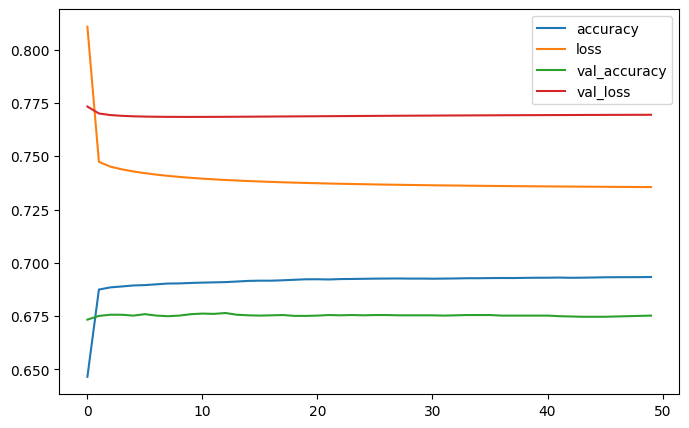

In [94]:
# 2 layers, 4 nodes in layer 1, 2 nodes in layer 2

tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(4))
model.add(tf.keras.layers.Dense(2))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 293us/step - accuracy: 0.5798 - loss: 0.9067 - val_accuracy: 0.6759 - val_loss: 0.7738
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step - accuracy: 0.6859 - loss: 0.7490 - val_accuracy: 0.6743 - val_loss: 0.7694
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step - accuracy: 0.6875 - loss: 0.7451 - val_accuracy: 0.6754 - val_loss: 0.7689
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step - accuracy: 0.6873 - loss: 0.7439 - val_accuracy: 0.6751 - val_loss: 0.7686
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step - accuracy: 0.6880 - loss: 0.7430 - val_accuracy: 0.6749 - val_loss: 0.7684
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step - accuracy: 0.6888 - loss: 0.7423 - val_accuracy: 0.6749 - val_loss: 0.7683
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step - accuracy: 0.6894 - loss: 0.7416 - val_accuracy: 0.6750 - val_loss: 0.7682
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step - accuracy: 0.6901 -

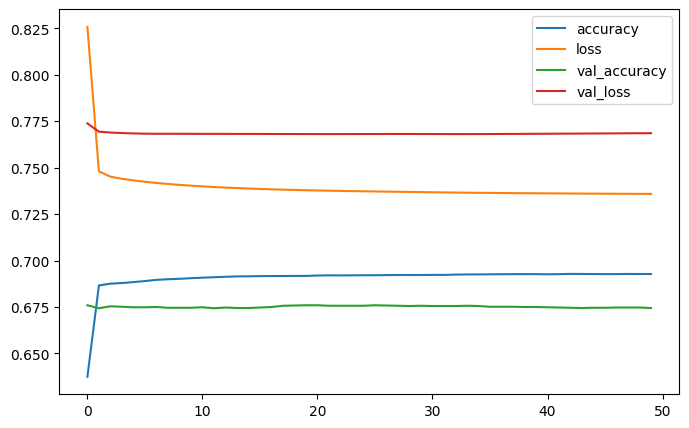

In [95]:
# 2 layers, 4 nodes in layer 1, 4 nodes in layer 2

tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(4))
model.add(tf.keras.layers.Dense(4))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 308us/step - accuracy: 0.5844 - loss: 0.9033 - val_accuracy: 0.6738 - val_loss: 0.7734
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 274us/step - accuracy: 0.6871 - loss: 0.7490 - val_accuracy: 0.6755 - val_loss: 0.7704
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step - accuracy: 0.6876 - loss: 0.7460 - val_accuracy: 0.6757 - val_loss: 0.7697
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step - accuracy: 0.6884 - loss: 0.7445 - val_accuracy: 0.6750 - val_loss: 0.7693
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step - accuracy: 0.6887 - loss: 0.7434 - val_accuracy: 0.6757 - val_loss: 0.7692
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step - accuracy: 0.6893 - loss: 0.7426 - val_accuracy: 0.6755 - val_loss: 0.7692
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step - accuracy: 0.6895 - loss: 0.7419 - val_accuracy: 0.6763 - val_loss: 0.7693
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step - accuracy: 0.6896 -

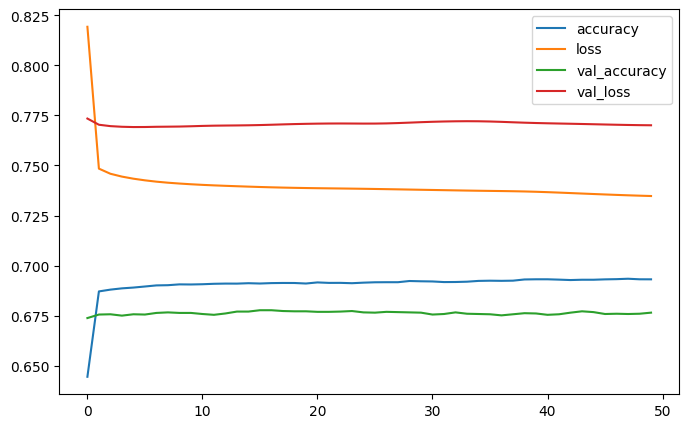

In [96]:
# 2 layers, 8 nodes in layer 1, 4 nodes in layer 2

tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(8))
model.add(tf.keras.layers.Dense(4))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 378us/step - accuracy: 0.6088 - loss: 0.8695 - val_accuracy: 0.6754 - val_loss: 0.7730
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 324us/step - accuracy: 0.6865 - loss: 0.7502 - val_accuracy: 0.6753 - val_loss: 0.7712
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step - accuracy: 0.6875 - loss: 0.7475 - val_accuracy: 0.6758 - val_loss: 0.7705
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step - accuracy: 0.6880 - loss: 0.7457 - val_accuracy: 0.6761 - val_loss: 0.7701
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step - accuracy: 0.6880 - loss: 0.7444 - val_accuracy: 0.6761 - val_loss: 0.7699
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step - accuracy: 0.6885 - loss: 0.7434 - val_accuracy: 0.6765 - val_loss: 0.7697
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step - accuracy: 0.6886 - loss: 0.7427 - val_accuracy: 0.6767 - val_loss: 0.7696
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step - accuracy: 0.6890 -

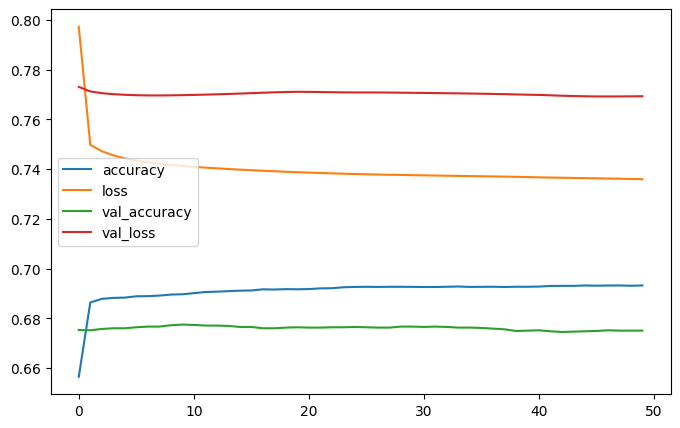

In [97]:
# 2 layers, 8 nodes in layer 1, 8 nodes in layer 2

tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(8))
model.add(tf.keras.layers.Dense(8))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 318us/step - accuracy: 0.6216 - loss: 0.8468 - val_accuracy: 0.6732 - val_loss: 0.7756
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 313us/step - accuracy: 0.6848 - loss: 0.7532 - val_accuracy: 0.6750 - val_loss: 0.7737
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 291us/step - accuracy: 0.6854 - loss: 0.7501 - val_accuracy: 0.6759 - val_loss: 0.7731
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 295us/step - accuracy: 0.6860 - loss: 0.7482 - val_accuracy: 0.6744 - val_loss: 0.7731
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 353us/step - accuracy: 0.6866 - loss: 0.7469 - val_accuracy: 0.6743 - val_loss: 0.7733
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 320us/step - accuracy: 0.6868 - loss: 0.7460 - val_accuracy: 0.6744 - val_loss: 0.7736
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 284us/step - accuracy: 0.6871 - loss: 0.7453 - val_accuracy: 0.6750 - val_loss: 0.7739
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step - accuracy: 0.6873 -

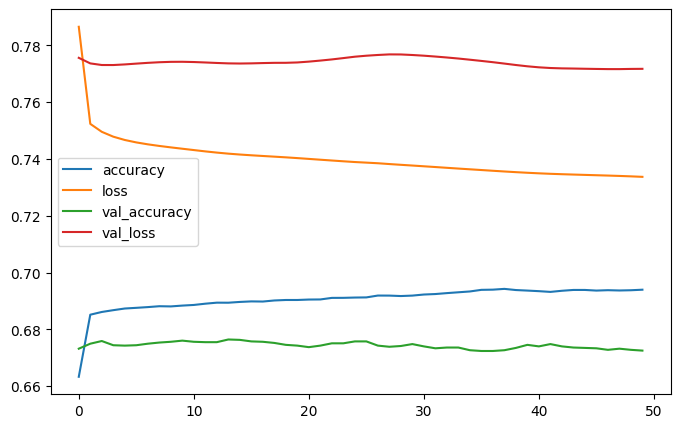

In [98]:
# 2 layers, 16 nodes in layer 1, 8 nodes in layer 2

tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(16))
model.add(tf.keras.layers.Dense(8))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 313us/step - accuracy: 0.6213 - loss: 0.8488 - val_accuracy: 0.6720 - val_loss: 0.7749
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 281us/step - accuracy: 0.6850 - loss: 0.7527 - val_accuracy: 0.6771 - val_loss: 0.7729
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 281us/step - accuracy: 0.6857 - loss: 0.7497 - val_accuracy: 0.6759 - val_loss: 0.7722
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 285us/step - accuracy: 0.6865 - loss: 0.7479 - val_accuracy: 0.6765 - val_loss: 0.7720
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 316us/step - accuracy: 0.6872 - loss: 0.7466 - val_accuracy: 0.6762 - val_loss: 0.7719
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 282us/step - accuracy: 0.6873 - loss: 0.7456 - val_accuracy: 0.6771 - val_loss: 0.7719
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 272us/step - accuracy: 0.6881 - loss: 0.7448 - val_accuracy: 0.6763 - val_loss: 0.7720
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step - accuracy: 0.6879 -

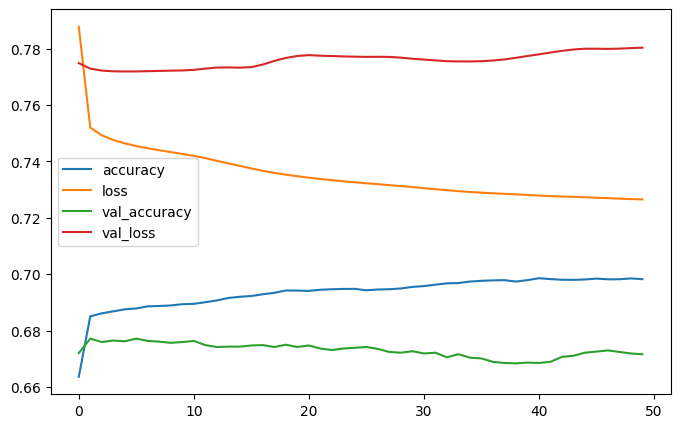

In [99]:
# 2 layers, 16 nodes in layer 1, 16 nodes in layer 2

tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(16))
model.add(tf.keras.layers.Dense(16))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 334us/step - accuracy: 0.6327 - loss: 0.8298 - val_accuracy: 0.6749 - val_loss: 0.7768
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 294us/step - accuracy: 0.6838 - loss: 0.7555 - val_accuracy: 0.6757 - val_loss: 0.7741
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 289us/step - accuracy: 0.6854 - loss: 0.7512 - val_accuracy: 0.6747 - val_loss: 0.7738
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 286us/step - accuracy: 0.6857 - loss: 0.7485 - val_accuracy: 0.6743 - val_loss: 0.7741
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 293us/step - accuracy: 0.6872 - loss: 0.7463 - val_accuracy: 0.6734 - val_loss: 0.7742
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 297us/step - accuracy: 0.6881 - loss: 0.7447 - val_accuracy: 0.6744 - val_loss: 0.7742
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 284us/step - accuracy: 0.6884 - loss: 0.7435 - val_accuracy: 0.6746 - val_loss: 0.7741
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 297us/step - accuracy: 0.6883 -

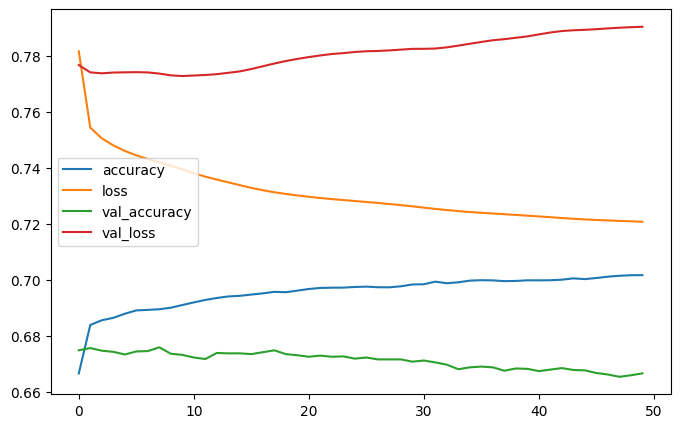

In [100]:
# 2 layers, 32 nodes in layer 1, 16 nodes in layer 2

tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dense(16))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 338us/step - accuracy: 0.6310 - loss: 0.8316 - val_accuracy: 0.6727 - val_loss: 0.7785
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 295us/step - accuracy: 0.6822 - loss: 0.7567 - val_accuracy: 0.6755 - val_loss: 0.7759
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 289us/step - accuracy: 0.6837 - loss: 0.7526 - val_accuracy: 0.6753 - val_loss: 0.7750
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 292us/step - accuracy: 0.6851 - loss: 0.7500 - val_accuracy: 0.6754 - val_loss: 0.7746
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 297us/step - accuracy: 0.6864 - loss: 0.7477 - val_accuracy: 0.6751 - val_loss: 0.7748
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 299us/step - accuracy: 0.6881 - loss: 0.7454 - val_accuracy: 0.6747 - val_loss: 0.7761
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 291us/step - accuracy: 0.6891 - loss: 0.7433 - val_accuracy: 0.6734 - val_loss: 0.7774
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 294us/step - accuracy: 0.6908 -

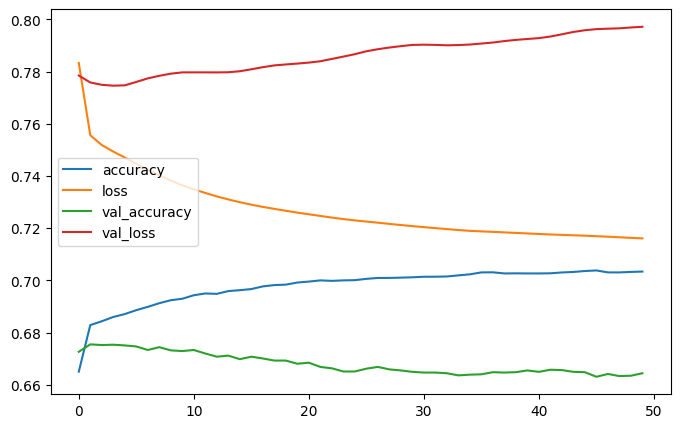

In [101]:
# 2 layers, 32 nodes in layer 1, 32 nodes in layer 2

tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 377us/step - accuracy: 0.6379 - loss: 0.8219 - val_accuracy: 0.6742 - val_loss: 0.7796
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 329us/step - accuracy: 0.6813 - loss: 0.7585 - val_accuracy: 0.6731 - val_loss: 0.7773
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 359us/step - accuracy: 0.6843 - loss: 0.7525 - val_accuracy: 0.6736 - val_loss: 0.7774
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 328us/step - accuracy: 0.6868 - loss: 0.7481 - val_accuracy: 0.6747 - val_loss: 0.7773
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 338us/step - accuracy: 0.6883 - loss: 0.7443 - val_accuracy: 0.6732 - val_loss: 0.7763
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 330us/step - accuracy: 0.6904 - loss: 0.7407 - val_accuracy: 0.6728 - val_loss: 0.7764
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 332us/step - accuracy: 0.6922 - loss: 0.7376 - val_accuracy: 0.6704 - val_loss: 0.7785
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 338us/step - accuracy: 0.6931 -

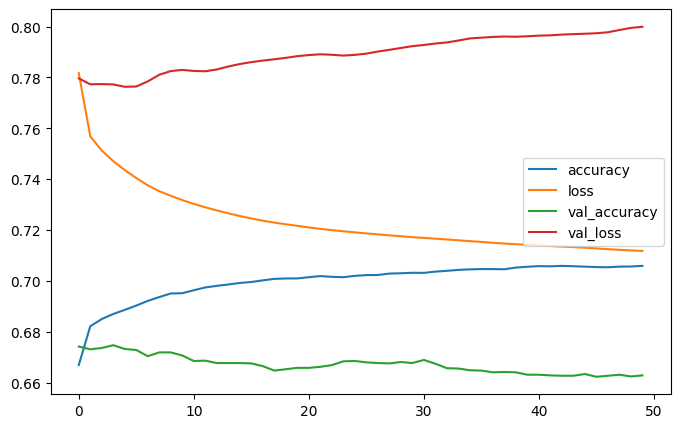

In [102]:
# 2 layers, 64 nodes in layer 1, 32 nodes in layer 2

tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 398us/step - accuracy: 0.6388 - loss: 0.8235 - val_accuracy: 0.6723 - val_loss: 0.7824
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 356us/step - accuracy: 0.6815 - loss: 0.7588 - val_accuracy: 0.6735 - val_loss: 0.7794
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 338us/step - accuracy: 0.6850 - loss: 0.7516 - val_accuracy: 0.6736 - val_loss: 0.7798
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 338us/step - accuracy: 0.6887 - loss: 0.7463 - val_accuracy: 0.6727 - val_loss: 0.7803
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 348us/step - accuracy: 0.6911 - loss: 0.7416 - val_accuracy: 0.6728 - val_loss: 0.7810
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 328us/step - accuracy: 0.6927 - loss: 0.7375 - val_accuracy: 0.6712 - val_loss: 0.7822
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 346us/step - accuracy: 0.6957 - loss: 0.7342 - val_accuracy: 0.6697 - val_loss: 0.7830
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 343us/step - accuracy: 0.6962 -

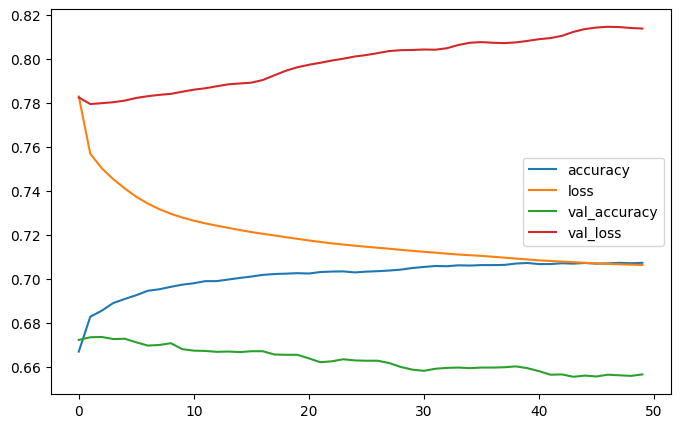

In [103]:
# 2 layers, 64 nodes in layer 1, 64 nodes in layer 2

tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 471us/step - accuracy: 0.6420 - loss: 0.8200 - val_accuracy: 0.6707 - val_loss: 0.7847
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 422us/step - accuracy: 0.6811 - loss: 0.7594 - val_accuracy: 0.6723 - val_loss: 0.7799
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 428us/step - accuracy: 0.6865 - loss: 0.7496 - val_accuracy: 0.6722 - val_loss: 0.7807
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 463us/step - accuracy: 0.6902 - loss: 0.7433 - val_accuracy: 0.6732 - val_loss: 0.7827
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 411us/step - accuracy: 0.6935 - loss: 0.7380 - val_accuracy: 0.6711 - val_loss: 0.7852
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 433us/step - accuracy: 0.6953 - loss: 0.7340 - val_accuracy: 0.6668 - val_loss: 0.7862
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 413us/step - accuracy: 0.6972 - loss: 0.7305 - val_accuracy: 0.6647 - val_loss: 0.7886
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 403us/step - accuracy: 0.6984 -

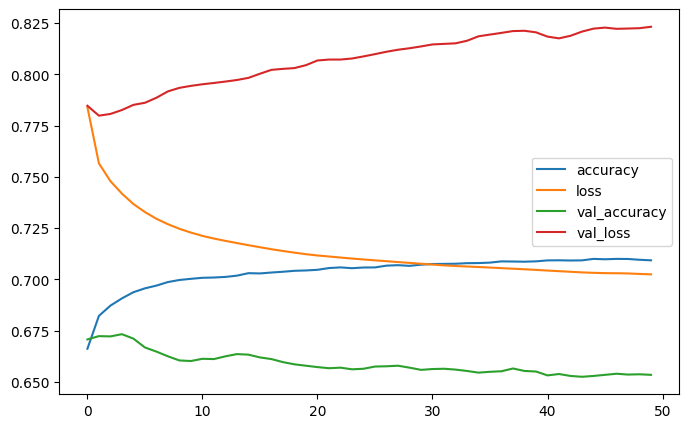

In [104]:
# 2 layers, 128 nodes in layer 1, 64 nodes in layer 2

tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 513us/step - accuracy: 0.6475 - loss: 0.8176 - val_accuracy: 0.6703 - val_loss: 0.7858
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 482us/step - accuracy: 0.6804 - loss: 0.7593 - val_accuracy: 0.6712 - val_loss: 0.7820
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 474us/step - accuracy: 0.6869 - loss: 0.7487 - val_accuracy: 0.6701 - val_loss: 0.7835
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 471us/step - accuracy: 0.6916 - loss: 0.7411 - val_accuracy: 0.6685 - val_loss: 0.7862
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.6942 - loss: 0.7353 - val_accuracy: 0.6681 - val_loss: 0.7889
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 456us/step - accuracy: 0.6968 - loss: 0.7307 - val_accuracy: 0.6651 - val_loss: 0.7916
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 462us/step - accuracy: 0.6987 - loss: 0.7270 - val_accuracy: 0.6649 - val_loss: 0.7937
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 444us/step - accuracy: 0.6999 -

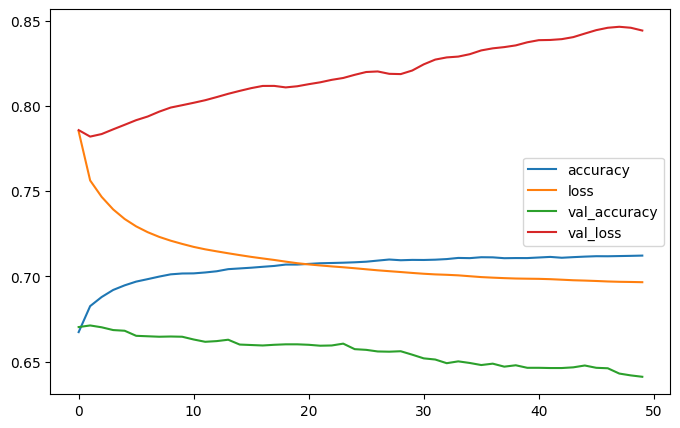

In [105]:
# 2 layers, 128 nodes in layer 1, 128 nodes in layer 2

tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 736us/step - accuracy: 0.6442 - loss: 0.8191 - val_accuracy: 0.6693 - val_loss: 0.7872
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 690us/step - accuracy: 0.6822 - loss: 0.7588 - val_accuracy: 0.6724 - val_loss: 0.7830
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 671us/step - accuracy: 0.6883 - loss: 0.7466 - val_accuracy: 0.6689 - val_loss: 0.7867
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 655us/step - accuracy: 0.6925 - loss: 0.7377 - val_accuracy: 0.6668 - val_loss: 0.7922
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 686us/step - accuracy: 0.6953 - loss: 0.7313 - val_accuracy: 0.6628 - val_loss: 0.7966
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 679us/step - accuracy: 0.6986 - loss: 0.7262 - val_accuracy: 0.6624 - val_loss: 0.7998
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 688us/step - accuracy: 0.7003 - loss: 0.7223 - val_accuracy: 0.6600 - val_loss: 0.8025
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 685us/step - accuracy: 0.7017 -

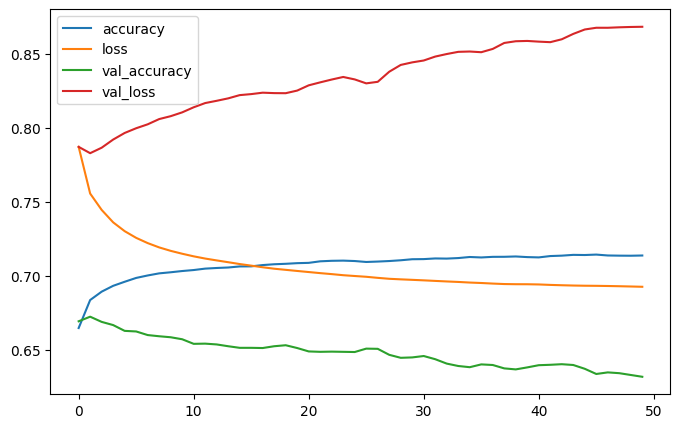

In [106]:
# 2 layers, 256 nodes in layer 1, 128 nodes in layer 2

tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 2s 913us/step - accuracy: 0.6425 - loss: 0.8218 - val_accuracy: 0.6693 - val_loss: 0.7876
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 2s 859us/step - accuracy: 0.6822 - loss: 0.7584 - val_accuracy: 0.6691 - val_loss: 0.7865
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 2s 854us/step - accuracy: 0.6895 - loss: 0.7450 - val_accuracy: 0.6668 - val_loss: 0.7935
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 2s 879us/step - accuracy: 0.6934 - loss: 0.7350 - val_accuracy: 0.6619 - val_loss: 0.8032
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 2s 892us/step - accuracy: 0.6955 - loss: 0.7282 - val_accuracy: 0.6595 - val_loss: 0.8112
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 2s 865us/step - accuracy: 0.6982 - loss: 0.7229 - val_accuracy: 0.6558 - val_loss: 0.8175
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 2s 836us/step - accuracy: 0.7005 - loss: 0.7186 - val_accuracy: 0.6546 - val_loss: 0.8223
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 2s 871us/step - accuracy: 0.7016 -

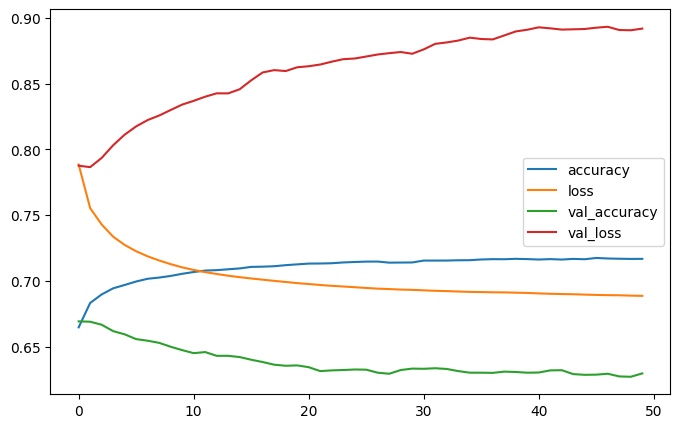

In [107]:
# 2 layers, 256 nodes in layer 1, 256 nodes in layer 2

tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6375 - loss: 0.8263 - val_accuracy: 0.6703 - val_loss: 0.7884
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6824 - loss: 0.7575 - val_accuracy: 0.6693 - val_loss: 0.7895
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6892 - loss: 0.7429 - val_accuracy: 0.6642 - val_loss: 0.7999
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6937 - loss: 0.7330 - val_accuracy: 0.6593 - val_loss: 0.8079
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6972 - loss: 0.7258 - val_accuracy: 0.6546 - val_loss: 0.8175
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6995 - loss: 0.7206 - val_accuracy: 0.6493 - val_loss: 0.8258
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7019 - loss: 0.7165 - val_accuracy: 0.6481 - val_loss: 0.8325
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7029 - loss: 0.7131 - 

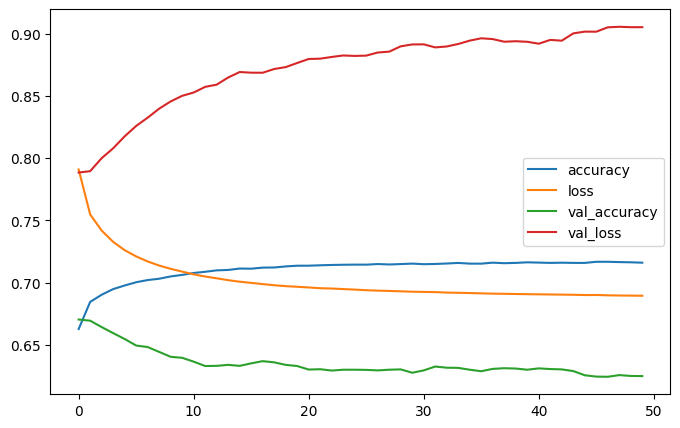

In [108]:
# 2 layers, 512 nodes in layer 1, 256 nodes in layer 2

tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512))
model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6387 - loss: 0.8315 - val_accuracy: 0.6677 - val_loss: 0.7911
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6824 - loss: 0.7582 - val_accuracy: 0.6637 - val_loss: 0.7970
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6891 - loss: 0.7420 - val_accuracy: 0.6581 - val_loss: 0.8104
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6941 - loss: 0.7314 - val_accuracy: 0.6508 - val_loss: 0.8250
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6976 - loss: 0.7243 - val_accuracy: 0.6442 - val_loss: 0.8373
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7010 - loss: 0.7194 - val_accuracy: 0.6415 - val_loss: 0.8465
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7035 - loss: 0.7157 - val_accuracy: 0.6388 - val_loss: 0.8551
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7051 - loss: 0.7126 - 

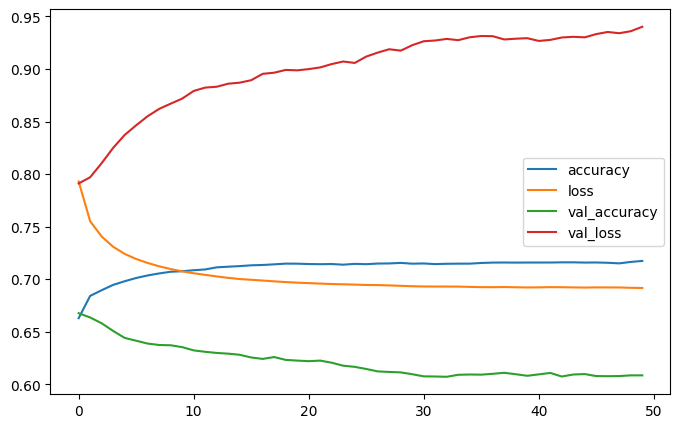

In [109]:
# 2 layers, 512 nodes in layer 1, 512 nodes in layer 2

tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512))
model.add(tf.keras.layers.Dense(512))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 296us/step - accuracy: 0.4612 - loss: 1.0281 - val_accuracy: 0.5573 - val_loss: 0.9292
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step - accuracy: 0.5842 - loss: 0.9008 - val_accuracy: 0.5785 - val_loss: 0.9127
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step - accuracy: 0.6042 - loss: 0.8844 - val_accuracy: 0.5952 - val_loss: 0.9007
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step - accuracy: 0.6159 - loss: 0.8720 - val_accuracy: 0.6012 - val_loss: 0.8928
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step - accuracy: 0.6200 - loss: 0.8653 - val_accuracy: 0.6031 - val_loss: 0.8897
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step - accuracy: 0.6204 - loss: 0.8627 - val_accuracy: 0.6036 - val_loss: 0.8886
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step - accuracy: 0.6208 - loss: 0.8617 - val_accuracy: 0.6029 - val_loss: 0.8881
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step - accuracy: 0.6211 -

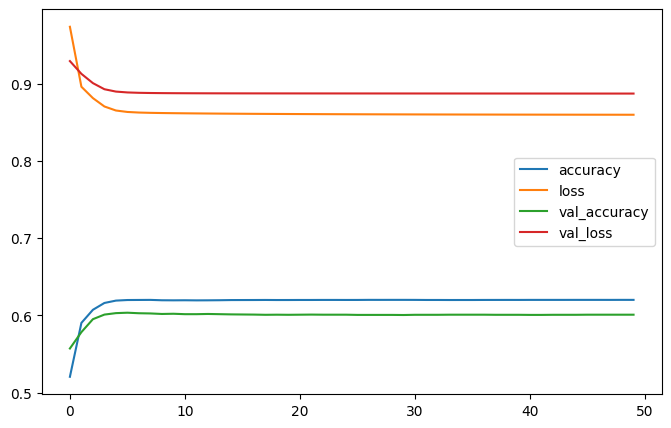

In [112]:
# 3 layers, 1 node in layer 1, 1 node in layer 2, 1 node in layer 3

tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1))
model.add(tf.keras.layers.Dense(1))
model.add(tf.keras.layers.Dense(1))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 320us/step - accuracy: 0.5198 - loss: 0.9862 - val_accuracy: 0.5935 - val_loss: 0.9040
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 273us/step - accuracy: 0.6139 - loss: 0.8762 - val_accuracy: 0.6012 - val_loss: 0.8924
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step - accuracy: 0.6196 - loss: 0.8665 - val_accuracy: 0.6041 - val_loss: 0.8895
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step - accuracy: 0.6191 - loss: 0.8640 - val_accuracy: 0.6036 - val_loss: 0.8887
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step - accuracy: 0.6201 - loss: 0.8630 - val_accuracy: 0.6029 - val_loss: 0.8883
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step - accuracy: 0.6196 - loss: 0.8624 - val_accuracy: 0.6022 - val_loss: 0.8880
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 306us/step - accuracy: 0.6196 - loss: 0.8620 - val_accuracy: 0.6021 - val_loss: 0.8879
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 301us/step - accuracy: 0.6197 -

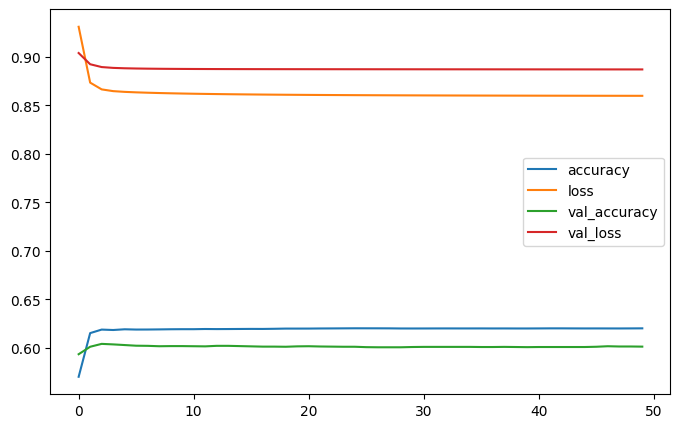

In [113]:
# 3 layers, 2 nodes in layer 1, 1 node in layer 2, 1 node in layer 3

tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(2))
model.add(tf.keras.layers.Dense(1))
model.add(tf.keras.layers.Dense(1))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 308us/step - accuracy: 0.5338 - loss: 0.9600 - val_accuracy: 0.6771 - val_loss: 0.7756
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step - accuracy: 0.6853 - loss: 0.7507 - val_accuracy: 0.6753 - val_loss: 0.7695
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step - accuracy: 0.6903 - loss: 0.7436 - val_accuracy: 0.6753 - val_loss: 0.7693
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step - accuracy: 0.6902 - loss: 0.7421 - val_accuracy: 0.6743 - val_loss: 0.7693
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step - accuracy: 0.6904 - loss: 0.7413 - val_accuracy: 0.6738 - val_loss: 0.7692
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 275us/step - accuracy: 0.6911 - loss: 0.7406 - val_accuracy: 0.6736 - val_loss: 0.7691
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step - accuracy: 0.6916 - loss: 0.7401 - val_accuracy: 0.6734 - val_loss: 0.7691
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step - accuracy: 0.6918 -

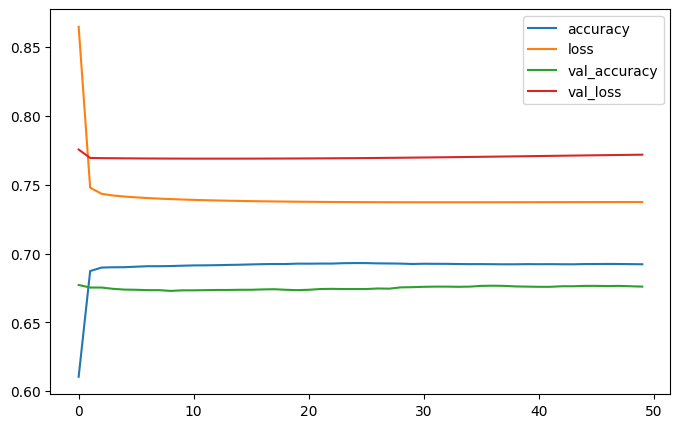

In [114]:
# 3 layers, 2 nodes in layer 1, 2 nodes in layer 2, 2 nodes in layer 3

tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(2))
model.add(tf.keras.layers.Dense(2))
model.add(tf.keras.layers.Dense(2))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 318us/step - accuracy: 0.4577 - loss: 0.9924 - val_accuracy: 0.5306 - val_loss: 0.9482
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step - accuracy: 0.5408 - loss: 0.9298 - val_accuracy: 0.5577 - val_loss: 0.9363
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step - accuracy: 0.5747 - loss: 0.9136 - val_accuracy: 0.5657 - val_loss: 0.9260
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 272us/step - accuracy: 0.5854 - loss: 0.9014 - val_accuracy: 0.5740 - val_loss: 0.9150
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step - accuracy: 0.6011 - loss: 0.8872 - val_accuracy: 0.5982 - val_loss: 0.8991
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step - accuracy: 0.6172 - loss: 0.8713 - val_accuracy: 0.6025 - val_loss: 0.8912
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 280us/step - accuracy: 0.6198 - loss: 0.8650 - val_accuracy: 0.6033 - val_loss: 0.8890
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 273us/step - accuracy: 0.6200 -

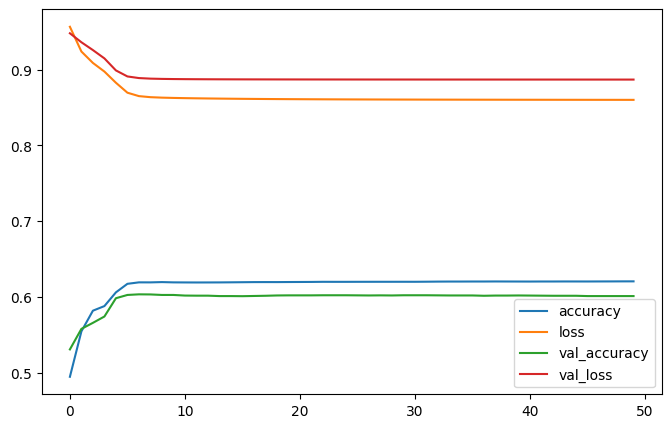

In [115]:
# 3 layers, 4 nodes in layer 1, 2 nodes in layer 2, 1 nodes in layer 3

tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(4))
model.add(tf.keras.layers.Dense(2))
model.add(tf.keras.layers.Dense(1))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 308us/step - accuracy: 0.5801 - loss: 0.8999 - val_accuracy: 0.6734 - val_loss: 0.7705
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step - accuracy: 0.6873 - loss: 0.7473 - val_accuracy: 0.6743 - val_loss: 0.7697
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step - accuracy: 0.6883 - loss: 0.7450 - val_accuracy: 0.6754 - val_loss: 0.7694
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step - accuracy: 0.6885 - loss: 0.7438 - val_accuracy: 0.6762 - val_loss: 0.7691
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 272us/step - accuracy: 0.6890 - loss: 0.7429 - val_accuracy: 0.6761 - val_loss: 0.7690
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 271us/step - accuracy: 0.6898 - loss: 0.7422 - val_accuracy: 0.6754 - val_loss: 0.7689
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step - accuracy: 0.6900 - loss: 0.7416 - val_accuracy: 0.6759 - val_loss: 0.7689
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step - accuracy: 0.6899 -

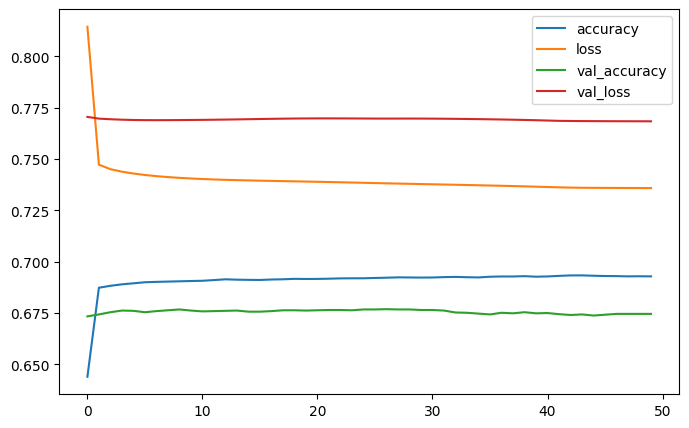

In [116]:
# 3 layers, 4 nodes in layer 1, 4 nodes in layer 2, 4 nodes in layer 3

tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(4))
model.add(tf.keras.layers.Dense(4))
model.add(tf.keras.layers.Dense(4))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 306us/step - accuracy: 0.5741 - loss: 0.8965 - val_accuracy: 0.6720 - val_loss: 0.7752
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 275us/step - accuracy: 0.6854 - loss: 0.7511 - val_accuracy: 0.6740 - val_loss: 0.7708
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 327us/step - accuracy: 0.6871 - loss: 0.7464 - val_accuracy: 0.6744 - val_loss: 0.7698
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step - accuracy: 0.6879 - loss: 0.7446 - val_accuracy: 0.6746 - val_loss: 0.7693
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 292us/step - accuracy: 0.6882 - loss: 0.7433 - val_accuracy: 0.6755 - val_loss: 0.7690
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 283us/step - accuracy: 0.6888 - loss: 0.7424 - val_accuracy: 0.6758 - val_loss: 0.7689
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 289us/step - accuracy: 0.6892 - loss: 0.7416 - val_accuracy: 0.6765 - val_loss: 0.7688
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 281us/step - accuracy: 0.6898 -

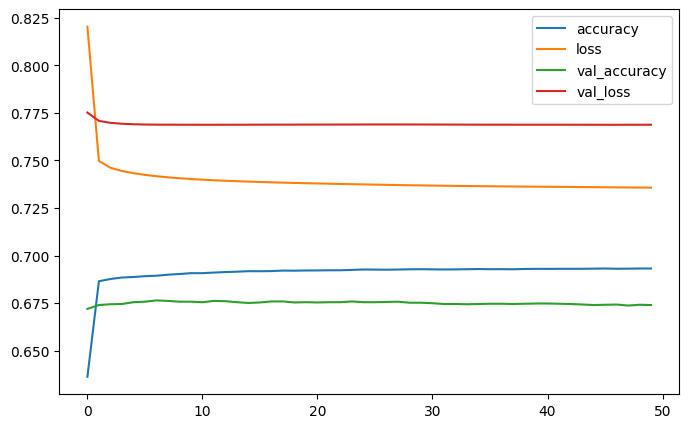

In [117]:
# 3 layers, 8 nodes in layer 1, 4 nodes in layer 2, 2 nodes in layer 3

tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(8))
model.add(tf.keras.layers.Dense(4))
model.add(tf.keras.layers.Dense(2))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 325us/step - accuracy: 0.6032 - loss: 0.8665 - val_accuracy: 0.6723 - val_loss: 0.7744
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 283us/step - accuracy: 0.6854 - loss: 0.7513 - val_accuracy: 0.6757 - val_loss: 0.7725
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 277us/step - accuracy: 0.6870 - loss: 0.7485 - val_accuracy: 0.6757 - val_loss: 0.7719
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 271us/step - accuracy: 0.6872 - loss: 0.7467 - val_accuracy: 0.6759 - val_loss: 0.7716
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step - accuracy: 0.6868 - loss: 0.7454 - val_accuracy: 0.6769 - val_loss: 0.7715
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step - accuracy: 0.6872 - loss: 0.7444 - val_accuracy: 0.6767 - val_loss: 0.7714
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step - accuracy: 0.6873 - loss: 0.7436 - val_accuracy: 0.6765 - val_loss: 0.7713
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 271us/step - accuracy: 0.6882 -

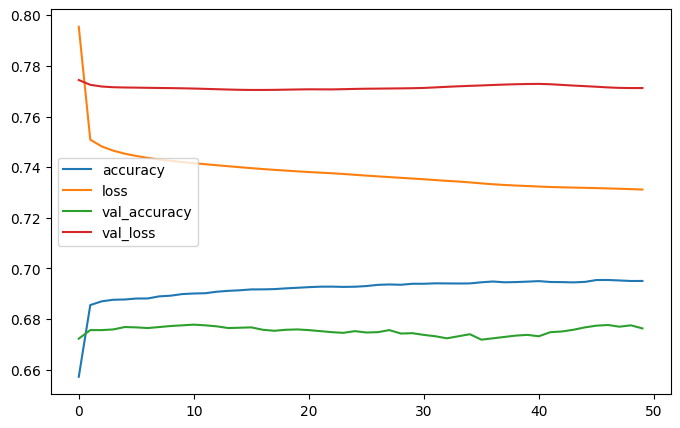

In [118]:
# 3 layers, 8 nodes in layer 1, 8 nodes in layer 2, 8 nodes in layer 3

tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(8))
model.add(tf.keras.layers.Dense(8))
model.add(tf.keras.layers.Dense(8))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 324us/step - accuracy: 0.6210 - loss: 0.8506 - val_accuracy: 0.6740 - val_loss: 0.7744
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 281us/step - accuracy: 0.6854 - loss: 0.7526 - val_accuracy: 0.6750 - val_loss: 0.7722
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 286us/step - accuracy: 0.6862 - loss: 0.7491 - val_accuracy: 0.6762 - val_loss: 0.7712
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 283us/step - accuracy: 0.6872 - loss: 0.7469 - val_accuracy: 0.6770 - val_loss: 0.7706
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 283us/step - accuracy: 0.6876 - loss: 0.7454 - val_accuracy: 0.6765 - val_loss: 0.7702
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 286us/step - accuracy: 0.6876 - loss: 0.7442 - val_accuracy: 0.6771 - val_loss: 0.7699
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 277us/step - accuracy: 0.6877 - loss: 0.7433 - val_accuracy: 0.6765 - val_loss: 0.7697
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 278us/step - accuracy: 0.6881 -

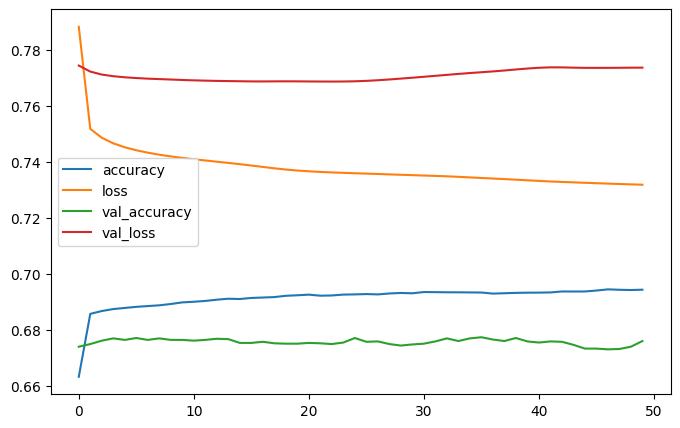

In [119]:
# 3 layers, 16 nodes in layer 1, 8 nodes in layer 2, 4 nodes in layer 3

tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(16))
model.add(tf.keras.layers.Dense(8))
model.add(tf.keras.layers.Dense(4))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 319us/step - accuracy: 0.6251 - loss: 0.8419 - val_accuracy: 0.6742 - val_loss: 0.7769
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 278us/step - accuracy: 0.6834 - loss: 0.7551 - val_accuracy: 0.6759 - val_loss: 0.7748
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 277us/step - accuracy: 0.6849 - loss: 0.7513 - val_accuracy: 0.6765 - val_loss: 0.7737
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 276us/step - accuracy: 0.6862 - loss: 0.7489 - val_accuracy: 0.6765 - val_loss: 0.7731
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 280us/step - accuracy: 0.6872 - loss: 0.7469 - val_accuracy: 0.6765 - val_loss: 0.7731
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 284us/step - accuracy: 0.6871 - loss: 0.7453 - val_accuracy: 0.6770 - val_loss: 0.7734
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 274us/step - accuracy: 0.6887 - loss: 0.7438 - val_accuracy: 0.6759 - val_loss: 0.7740
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 275us/step - accuracy: 0.6897 -

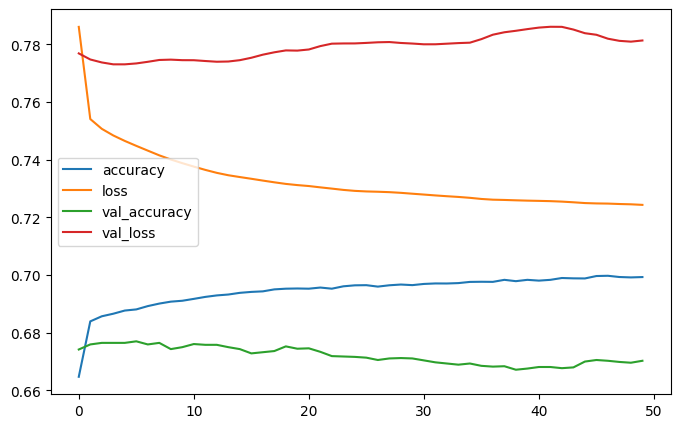

In [120]:
# 3 layers, 16 nodes in layer 1, 16 nodes in layer 2, 16 nodes in layer 3

tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(16))
model.add(tf.keras.layers.Dense(16))
model.add(tf.keras.layers.Dense(16))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 337us/step - accuracy: 0.6351 - loss: 0.8293 - val_accuracy: 0.6724 - val_loss: 0.7782
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 298us/step - accuracy: 0.6829 - loss: 0.7564 - val_accuracy: 0.6743 - val_loss: 0.7755
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 300us/step - accuracy: 0.6843 - loss: 0.7516 - val_accuracy: 0.6746 - val_loss: 0.7741
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 305us/step - accuracy: 0.6854 - loss: 0.7486 - val_accuracy: 0.6750 - val_loss: 0.7732
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 295us/step - accuracy: 0.6864 - loss: 0.7463 - val_accuracy: 0.6765 - val_loss: 0.7730
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 291us/step - accuracy: 0.6878 - loss: 0.7443 - val_accuracy: 0.6755 - val_loss: 0.7733
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 295us/step - accuracy: 0.6891 - loss: 0.7424 - val_accuracy: 0.6744 - val_loss: 0.7739
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 292us/step - accuracy: 0.6896 -

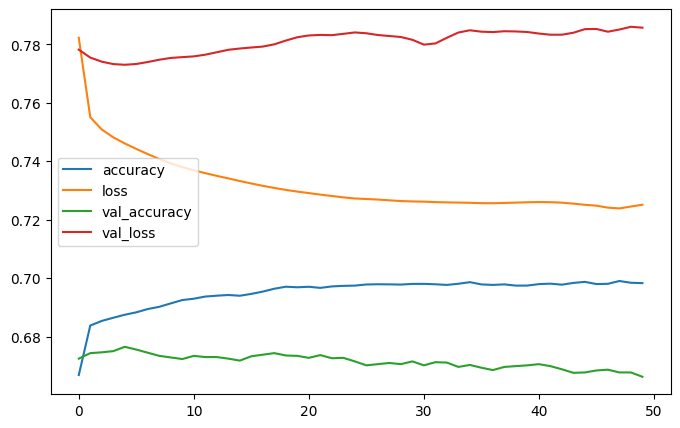

In [121]:
# 3 layers, 32 nodes in layer 1, 16 nodes in layer 2, 8 nodes in layer 3

tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dense(16))
model.add(tf.keras.layers.Dense(8))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 352us/step - accuracy: 0.6361 - loss: 0.8284 - val_accuracy: 0.6713 - val_loss: 0.7840
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 302us/step - accuracy: 0.6816 - loss: 0.7584 - val_accuracy: 0.6742 - val_loss: 0.7798
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 305us/step - accuracy: 0.6847 - loss: 0.7525 - val_accuracy: 0.6749 - val_loss: 0.7786
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 306us/step - accuracy: 0.6873 - loss: 0.7481 - val_accuracy: 0.6746 - val_loss: 0.7777
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 303us/step - accuracy: 0.6889 - loss: 0.7441 - val_accuracy: 0.6720 - val_loss: 0.7783
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 300us/step - accuracy: 0.6900 - loss: 0.7407 - val_accuracy: 0.6689 - val_loss: 0.7801
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 300us/step - accuracy: 0.6919 - loss: 0.7379 - val_accuracy: 0.6688 - val_loss: 0.7822
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 301us/step - accuracy: 0.6931 -

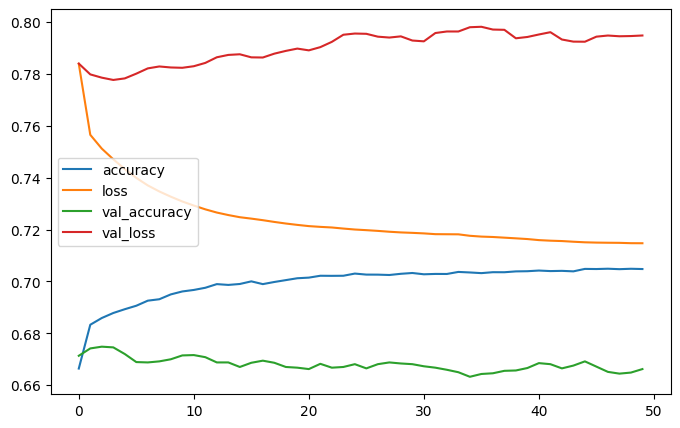

In [122]:
# 3 layers, 32 nodes in layer 1, 32 nodes in layer 2, 32 nodes in layer 3

tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 387us/step - accuracy: 0.6394 - loss: 0.8226 - val_accuracy: 0.6723 - val_loss: 0.7823
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 340us/step - accuracy: 0.6824 - loss: 0.7584 - val_accuracy: 0.6734 - val_loss: 0.7782
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 343us/step - accuracy: 0.6850 - loss: 0.7516 - val_accuracy: 0.6719 - val_loss: 0.7782
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 345us/step - accuracy: 0.6874 - loss: 0.7463 - val_accuracy: 0.6711 - val_loss: 0.7794
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 341us/step - accuracy: 0.6899 - loss: 0.7416 - val_accuracy: 0.6685 - val_loss: 0.7810
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 350us/step - accuracy: 0.6914 - loss: 0.7376 - val_accuracy: 0.6678 - val_loss: 0.7828
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 343us/step - accuracy: 0.6950 - loss: 0.7341 - val_accuracy: 0.6682 - val_loss: 0.7841
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 353us/step - accuracy: 0.6965 -

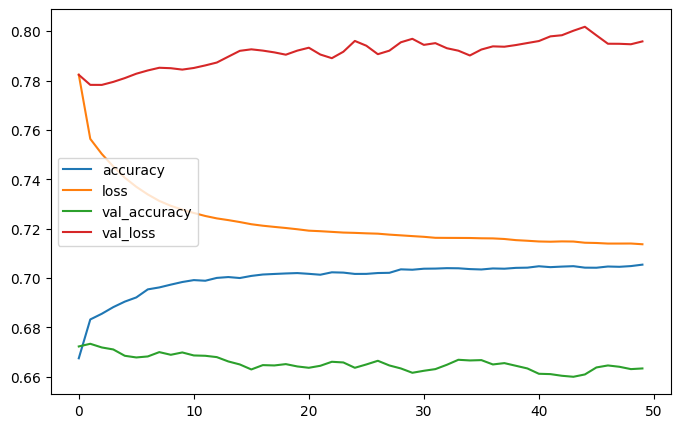

In [123]:
# 3 layers, 64 nodes in layer 1, 32 nodes in layer 2, 16 nodes in layer 3

tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dense(16))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 415us/step - accuracy: 0.6391 - loss: 0.8241 - val_accuracy: 0.6726 - val_loss: 0.7862
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 376us/step - accuracy: 0.6818 - loss: 0.7601 - val_accuracy: 0.6724 - val_loss: 0.7820
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 374us/step - accuracy: 0.6862 - loss: 0.7512 - val_accuracy: 0.6727 - val_loss: 0.7833
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 360us/step - accuracy: 0.6894 - loss: 0.7446 - val_accuracy: 0.6696 - val_loss: 0.7853
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 365us/step - accuracy: 0.6926 - loss: 0.7394 - val_accuracy: 0.6680 - val_loss: 0.7869
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 362us/step - accuracy: 0.6945 - loss: 0.7351 - val_accuracy: 0.6682 - val_loss: 0.7900
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 374us/step - accuracy: 0.6952 - loss: 0.7317 - val_accuracy: 0.6666 - val_loss: 0.7921
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 367us/step - accuracy: 0.6960 -

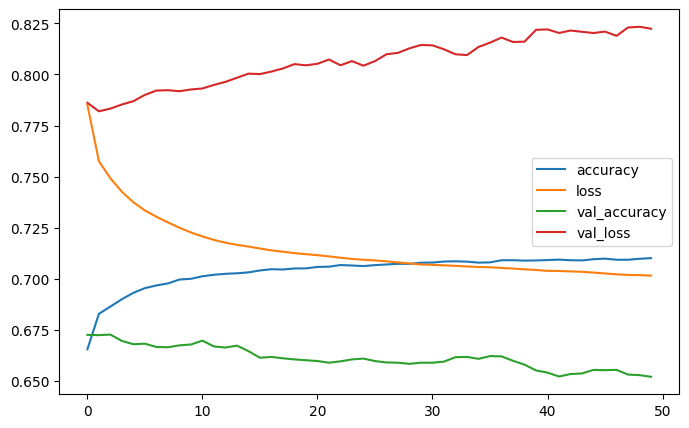

In [124]:
# 3 layers, 64 nodes in layer 1, 64 nodes in layer 2, 64 nodes in layer 3

tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.6397 - loss: 0.8211 - val_accuracy: 0.6708 - val_loss: 0.7867
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 429us/step - accuracy: 0.6823 - loss: 0.7594 - val_accuracy: 0.6722 - val_loss: 0.7830
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 418us/step - accuracy: 0.6891 - loss: 0.7485 - val_accuracy: 0.6704 - val_loss: 0.7847
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 420us/step - accuracy: 0.6907 - loss: 0.7401 - val_accuracy: 0.6703 - val_loss: 0.7876
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 412us/step - accuracy: 0.6936 - loss: 0.7339 - val_accuracy: 0.6705 - val_loss: 0.7899
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 420us/step - accuracy: 0.6958 - loss: 0.7294 - val_accuracy: 0.6681 - val_loss: 0.7929
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 420us/step - accuracy: 0.6981 - loss: 0.7263 - val_accuracy: 0.6670 - val_loss: 0.7933
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 426us/step - accuracy: 0.7003 -

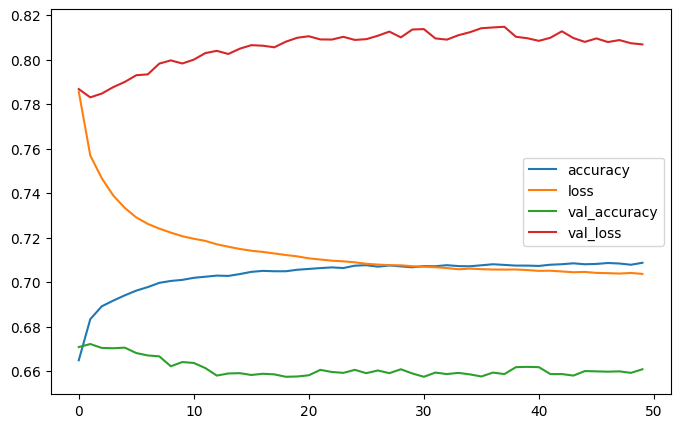

In [125]:
# 3 layers, 128 nodes in layer 1, 64 nodes in layer 2, 32 nodes in layer 3

tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 546us/step - accuracy: 0.6399 - loss: 0.8218 - val_accuracy: 0.6686 - val_loss: 0.7889
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 505us/step - accuracy: 0.6833 - loss: 0.7592 - val_accuracy: 0.6708 - val_loss: 0.7878
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step - accuracy: 0.6881 - loss: 0.7464 - val_accuracy: 0.6682 - val_loss: 0.7958
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 506us/step - accuracy: 0.6914 - loss: 0.7377 - val_accuracy: 0.6624 - val_loss: 0.8038
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 515us/step - accuracy: 0.6950 - loss: 0.7310 - val_accuracy: 0.6622 - val_loss: 0.8096
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 503us/step - accuracy: 0.6975 - loss: 0.7258 - val_accuracy: 0.6618 - val_loss: 0.8141
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step - accuracy: 0.6983 - loss: 0.7218 - val_accuracy: 0.6607 - val_loss: 0.8172
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/step - accuracy: 0.7009 -

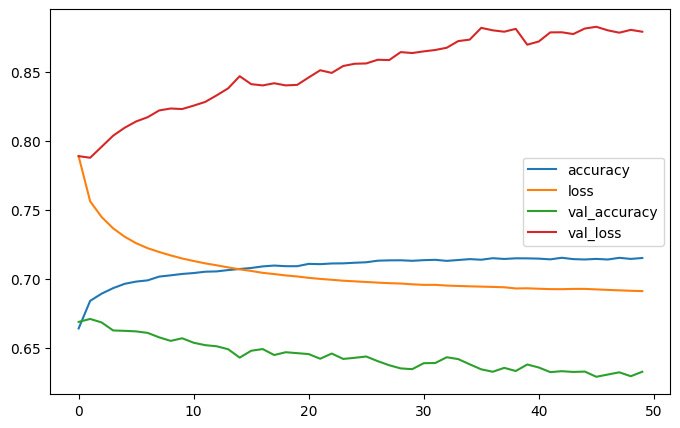

In [126]:
# 3 layers, 128 nodes in layer 1, 128 nodes in layer 2, 128 nodes in layer 3

tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 2s 772us/step - accuracy: 0.6435 - loss: 0.8220 - val_accuracy: 0.6699 - val_loss: 0.7900
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 706us/step - accuracy: 0.6815 - loss: 0.7589 - val_accuracy: 0.6699 - val_loss: 0.7894
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 705us/step - accuracy: 0.6880 - loss: 0.7446 - val_accuracy: 0.6653 - val_loss: 0.7921
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 677us/step - accuracy: 0.6917 - loss: 0.7354 - val_accuracy: 0.6610 - val_loss: 0.7988
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 683us/step - accuracy: 0.6938 - loss: 0.7299 - val_accuracy: 0.6626 - val_loss: 0.8029
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 699us/step - accuracy: 0.6972 - loss: 0.7256 - val_accuracy: 0.6610 - val_loss: 0.8061
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 688us/step - accuracy: 0.6985 - loss: 0.7218 - val_accuracy: 0.6611 - val_loss: 0.8107
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 687us/step - accuracy: 0.7012 -

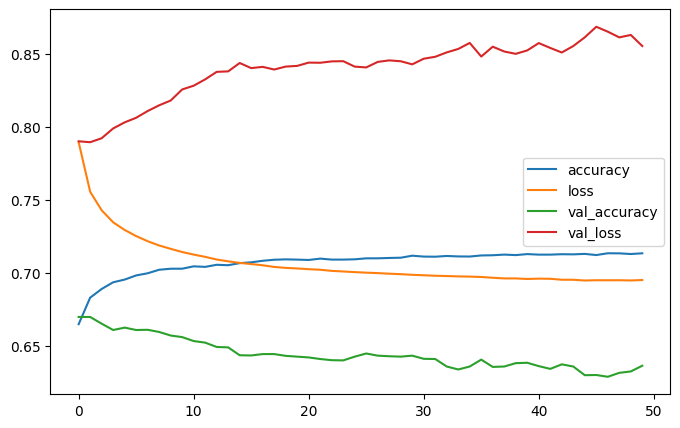

In [127]:
# 3 layers, 256 nodes in layer 1, 128 nodes in layer 2, 64 nodes in layer 3

tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6354 - loss: 0.8346 - val_accuracy: 0.6668 - val_loss: 0.7921
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6832 - loss: 0.7592 - val_accuracy: 0.6677 - val_loss: 0.7946
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6888 - loss: 0.7445 - val_accuracy: 0.6626 - val_loss: 0.8073
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6932 - loss: 0.7348 - val_accuracy: 0.6591 - val_loss: 0.8190
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6964 - loss: 0.7282 - val_accuracy: 0.6527 - val_loss: 0.8285
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6990 - loss: 0.7235 - val_accuracy: 0.6477 - val_loss: 0.8380
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7004 - loss: 0.7195 - val_accuracy: 0.6446 - val_loss: 0.8475
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7026 - loss: 0.7161 - 

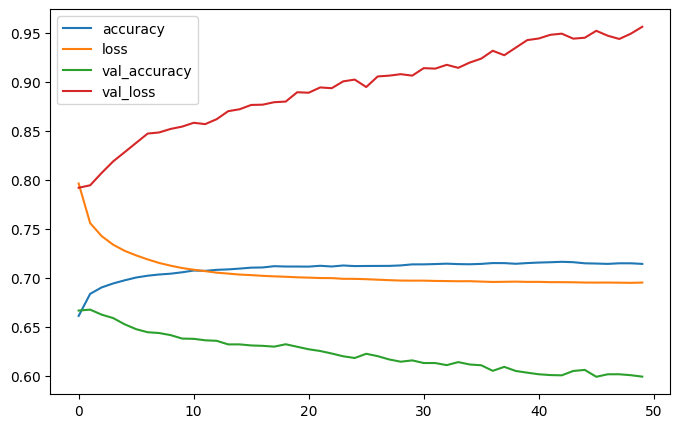

In [161]:
# 3 layers, 256 nodes in layer 1, 256 nodes in layer 2, 256 nodes in layer 3

tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6372 - loss: 0.8345 - val_accuracy: 0.6682 - val_loss: 0.7934
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6825 - loss: 0.7578 - val_accuracy: 0.6665 - val_loss: 0.7994
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6891 - loss: 0.7426 - val_accuracy: 0.6612 - val_loss: 0.8115
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6934 - loss: 0.7332 - val_accuracy: 0.6542 - val_loss: 0.8229
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6961 - loss: 0.7268 - val_accuracy: 0.6483 - val_loss: 0.8352
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6985 - loss: 0.7223 - val_accuracy: 0.6458 - val_loss: 0.8404
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7008 - loss: 0.7186 - val_accuracy: 0.6434 - val_loss: 0.8494
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7021 - loss: 0.7159 - 

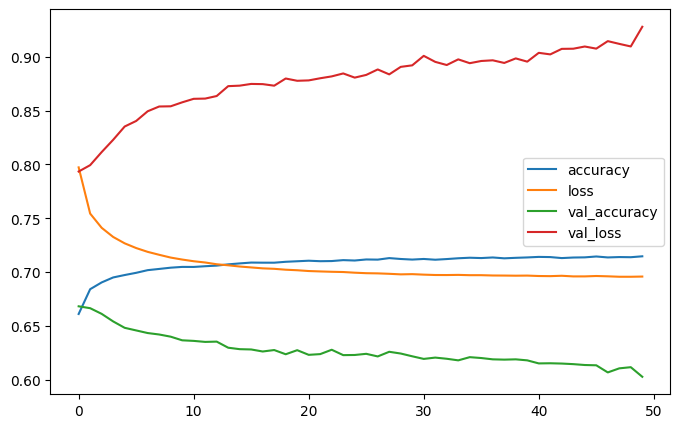

In [162]:
# 3 layers, 512 nodes in layer 1, 256 nodes in layer 2, 128 nodes in layer 3

tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512))
model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6273 - loss: 0.8501 - val_accuracy: 0.6678 - val_loss: 0.7975
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6817 - loss: 0.7608 - val_accuracy: 0.6514 - val_loss: 0.8180
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6879 - loss: 0.7445 - val_accuracy: 0.6408 - val_loss: 0.8483
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6949 - loss: 0.7349 - val_accuracy: 0.6368 - val_loss: 0.8678
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6981 - loss: 0.7287 - val_accuracy: 0.6319 - val_loss: 0.8829
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7010 - loss: 0.7246 - val_accuracy: 0.6241 - val_loss: 0.8960
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7014 - loss: 0.7218 - val_accuracy: 0.6190 - val_loss: 0.9088
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7036 - loss: 0.7199 - 

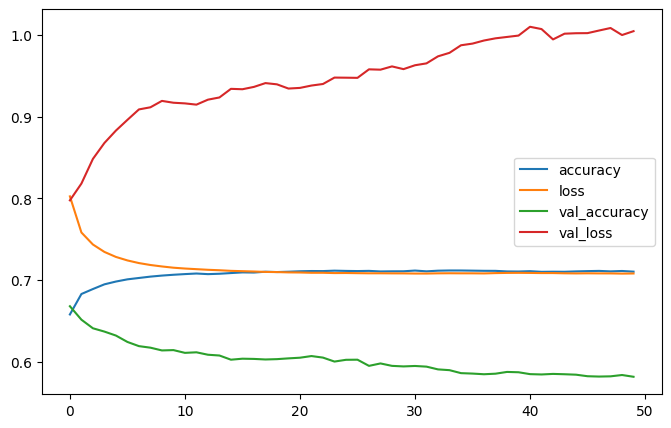

In [163]:
# 3 layers, 512 nodes in layer 1, 512 nodes in layer 2, 512 nodes in layer 3

tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512))
model.add(tf.keras.layers.Dense(512))
model.add(tf.keras.layers.Dense(512))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 2s 817us/step - accuracy: 0.5024 - loss: 0.9961 - val_accuracy: 0.5864 - val_loss: 0.9138
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 278us/step - accuracy: 0.6061 - loss: 0.8853 - val_accuracy: 0.6010 - val_loss: 0.8970
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 273us/step - accuracy: 0.6172 - loss: 0.8696 - val_accuracy: 0.6026 - val_loss: 0.8908
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 275us/step - accuracy: 0.6193 - loss: 0.8648 - val_accuracy: 0.6032 - val_loss: 0.8892
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 272us/step - accuracy: 0.6196 - loss: 0.8634 - val_accuracy: 0.6031 - val_loss: 0.8886
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 272us/step - accuracy: 0.6200 - loss: 0.8626 - val_accuracy: 0.6021 - val_loss: 0.8883
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 274us/step - accuracy: 0.6196 - loss: 0.8622 - val_accuracy: 0.6018 - val_loss: 0.8880
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 278us/step - accuracy: 0.6196 -

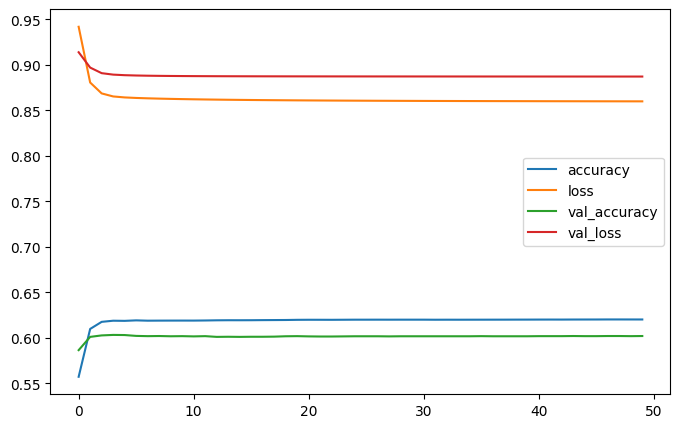

In [164]:
# 4 layers, 1 node in layer 1, 1 node in layer 2, 1 node in layer 3, 1 node in layer 4

tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1))
model.add(tf.keras.layers.Dense(1))
model.add(tf.keras.layers.Dense(1))
model.add(tf.keras.layers.Dense(1))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6179 - loss: 0.8752 - val_accuracy: 0.6650 - val_loss: 0.8009
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6780 - loss: 0.7677 - val_accuracy: 0.6587 - val_loss: 0.8101
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6866 - loss: 0.7517 - val_accuracy: 0.6560 - val_loss: 0.8207
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6909 - loss: 0.7427 - val_accuracy: 0.6480 - val_loss: 0.8379
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6944 - loss: 0.7364 - val_accuracy: 0.6376 - val_loss: 0.8551
Epoch 6/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6974 - loss: 0.7325 - val_accuracy: 0.6337 - val_loss: 0.8747
Epoch 7/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6991 - loss: 0.7297 - val_accuracy: 0.6299 - val_loss: 0.8748
Epoch 8/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6999 - loss: 0.7274 - 

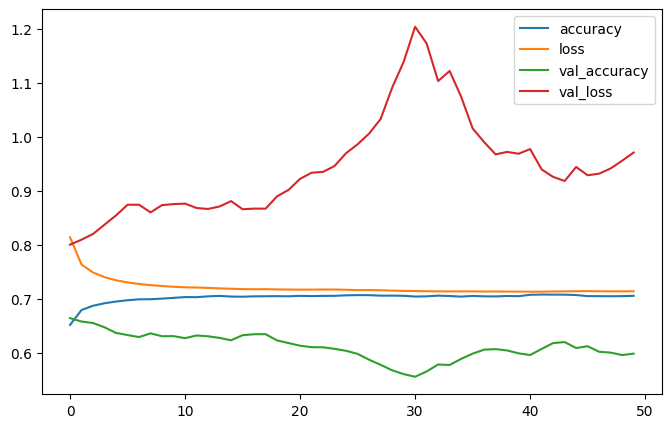

In [134]:
# 4 layers, 512 nodes in layer 1, 512 nodes in layer 2, 512 nodes in layer 3, 512 nodes in layer 4

tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512))
model.add(tf.keras.layers.Dense(512))
model.add(tf.keras.layers.Dense(512))
model.add(tf.keras.layers.Dense(512))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

    
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

- **Activation function**.

  - Present results for one of the configurations mentioned above by varying the activation function. Test at least `relu` (the default) and `sigmoid`. The choice of the specific model, including the number of layers and nodes, is at your discretion. Document your observations accordingly.

In [ ]:
# We use the neural network with 3 hidden layers, each with 4 nodes


- **Regularization** in neural networks is a technique used to prevent overfitting.

  - One technique involves adding a penalty to the loss function to discourage excessively complex models. Apply an `l2` penalty to some or all layers. Exercise caution, as overly aggressive penalties have been problematic in our experiments. Begin with the default `l2` value of 0.01, then reduce it to 0.001 and 1e-4. Select a specific model from the above experiments and present a case where you successfully reduced overfitting. Include a pair of graphs comparing results with and without regularization. Explain your rationale to conclude that overfitting has been reduced. Do not expect to completely eliminate overfitting. Again, this is a challenging dataset to work with.

In [ ]:
# Code cell

 - Dropout layers are a regularization technique in neural networks where a random subset of neurons is temporarily removed during training. This helps prevent overfitting by promoting redundancy and improving the network's ability to generalize to new data. Select a specific model from the above experiments where you have muliple layers and experiment adding one or of few dropout layers into your network. Experiment with two different rates, say 0.25 and 0.5. Document your observations.

In [ ]:
# Code cell

 - Summarize your experiments with using a graphical representation such as Figure 6.15 [on this page](https://egallic.fr/Enseignement/ML/ECB/book/deep-learning.html).

In [ ]:
# Code cell

- Early stopping is a regularization technique in neural network training wherein the process is halted when validation set performance starts to decline, thus preventing overfitting by avoiding the learning of noise in the training data. From all the experiments conducted thus far, choose **one** configuration (the number of layers, number of nodes, activation function, L2 penalty, and dropout layers) that yielded the best performance. Use a graph of loss and accuracy to determine the optimal number of training iterations for this network. What is the optimal number of epochs for this network configuration and why?

In [ ]:
# Code cell

### Test

9. **Model Comparison**:

    - Evaluate the baseline model on the test set, using the optimal parameter set identified through grid search. Additionally, apply your best-performing neural network configuration to the test set.

    - Quantify the performance of the baseline model (best hyperparameter configuration) and your neural network (best configuration) using precision, recall, and F1-score as metrics. How do these two models compare to the dummy model?

    - Provide recommendations on which model(s) to choose for this task and justify your choices based on the analysis results.

In [ ]:
# Code cell

# Resources